## Procedure
1. Choose variables.
2. Analyze each variables and test their causality by Granger causality test.
3. Modify data to obtain stationary
4. Examine the order and fit the model to the data
5. Split data into test one, and train one.
6. estimate the period of test data.
7. Evaluate the model and its estimates.
8. Retrain the model using all the data and estimate the future.
9. Test causal inference between variables.

1. Analyze the time series characteristics
2. Test for causation amongst the time series
3. Test for stationarity
4. Transform the series to make it stationary, if needed
5. Find optimal order (p)
6. Prepare training and test datasets
7. Train the model
8. Roll back the transformations, if any.
9. Evaluate the model using test set
10. Forecast to future

## Variables to use

1. Industrial Production Index (IPI)
2. the ratio of trade to GDP (TRADE)
3. the ratio of government final consumption expenditure (GCE)
4. Bank credit to private sector (BCP)
5. the ration of private sector's domestic credit to GDP (GDPP)
6. the ratio of M3 to GDP (GDPM)
7. the ratio of domestic savings to GDP (GDS)
8. interest rates New!
9. turnover ratio
10. the ratio of stock market total value traded to GDP (SMT)


World Bank Indicator
https://databank.worldbank.org/source/world-development-indicators#

入手できた変数
Domestic credit to private sector,
GDP growth,General government final consumption expenditure (% of GDP)
GCE, Gross domestic savings (% of GDP) GCS,
Domestic credit to private sector (% of GDP)→GDPP,
Stocks traded, total value (% of GDP)→SMT,
Trade (% of GDP),
Real interest rate (%)→RIR,
Deposit interest rate (%),
Domestic credit to private sector by banks (% of GDP)→BCP,
Broad money (% of GDP) instead of GCPM
turnover ratio：stocks traded, turnover ratio of domestic shares(%)
broad moneyへの変更などが特記事項．これは論文も変える必要がある．
## Database to check



FREDMD:id 80 : S&P 500, id 71 M2 Money stock,
Kaggle: IPI
World Bank WDI databaseーfinancial development：BCP, GDPP, GDS 年次
World Bank WDI databaseーfinancial development, stock market development：


World Bank WDI databaseからfinancial development, stock market development, real sector and economic growthなどもデータ入手先の候補
データソースは International Financial Statistics, South Africa Reserve Bank, Johannesburg Stock Exchange　ーUmar

In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
#ARモデル
from statsmodels.tsa.ar_model import AR,ARResults
#ARIMAモデル
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from pandas.plotting import lag_plot
import math
from statsmodels.stats.stattools import durbin_watson
# Ignore harmless warning
import warnings
warnings.filterwarnings("ignore")
# change options to display all outputs
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [8]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title = ""):
    """
    時系列を投入し，オプションでタイトルを決めると，ADFレポートを返す
    """
    print(f"Augumented Dickey-Fuller Test:{title}")
    result = adfuller(series.dropna(),autolag = "AIC") # .dropna() handles differenced data
    labels = ["ADS test statistic", "p-value", "# lags used", "# observations"] # # はnumberの略
    out = pd.Series(result[0:4],index = labels)

    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string()) # .to_string() は "dtype:float64"を取り除く

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return result[1]

#ここからadfなどもして前期との相関を見てくれる関数を作る
def plot_series(series, figsize = (9,6), title = "", model = "add"):
    season = seasonal_decompose(series,model = model)
    season.plot();

def plot_property(series, title = "", num = 30):
    lag_plot(series)
    plot_acf(series,lags = num, title = f"{title} ACF")
    plot_pacf(series,lags = num,title = f"{title} PACF")


def all_plot(data, title = "", figsize = (20,15),model = "add",series = False, acf = False ,num = 30,col = 2):
    """
    全てのデータをプロットする．オプションでacf, pacfもプロットできるはず
    """
    columns = data.columns
    fig, axes = plt.subplots(nrows= math.ceil(len(columns)/col), ncols=col, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i <= len(columns)-1:
            df = data[data.columns[i]]
            ax.plot(df, linewidth=1)
            ax.set_title(data.columns[i])
#             ax.xaxis.set_ticks_position('none')
#             ax.yaxis.set_ticks_position('none')
#             ax.spines["top"].set_alpha(0)
            ax.tick_params(labelsize=6)
            plt.subplots_adjust(hspace=1)
    if len(columns) % 2 != 0:
        ax.plot([0,0,0,0,0,0,0,0,0,0,0])
    for column in columns:
        if series == True:
            plot_series(data[column],title = column, model = model,figsize = figsize)
        if acf == True:
            plot_property(data[column], title = column, num = num)

#何個のdiffを取るべきかを明らかにする
def auto_adf(data):
    num = len(data.columns)
    #num_dic shows how many times the series need to be differenced
    num_dic = {}
    for x in range(num):
        result = adf_test(data.iloc[:,x])
        diff_num = 0
        series = data.iloc[:,x].diff()
        while result > 0.05:
            result = adf_test(series)
            series = series.diff()
            diff_num = diff_num + 1
        print(f"{data.columns[x]} needs {diff_num} times difference to obtain stationary")
        num_dic[data.columns[x]] = diff_num
        print("--------------------------------")
    return num_dic

#diffを行う回数分差分を取り，それを再びデータとして加える．
def differencing_data(data):
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    #辞書型のデータを取る
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        while diff_times != diff_num:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_num}"] = series
    return new_data.dropna()


#予測の関数を作る,　蜜柑

def ARforecast(original_data,num = 5,order = 6):
    """
    You need to input stationary data.
    The function automatically forecast with AR model.
    You can input DataFrame.
    The function returns the forecasts of variables and their lags in AR models as a dictionary.
    """
    data = differencing_data(original_data).dropna()
    train = data[:-num]
    test = data[-num:]
    lags = {}
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(index = idx,columns = data.columns)
    for key in data.columns:
        result_AIC = {}
        result_BIC = {}
        for i in range(1,order):
            model = AR(train[[key]])
            result = model.fit(i)
            result_AIC[i] = result.aic
            result_BIC[i] = result.bic
        min_AIC = min(result_AIC, key=result_AIC.get)
        min_BIC = min(result_BIC, key = result_BIC.get)
        md = AR(train[key])
        result = md.fit(min_AIC)
        print(result.summary())
        lag_order = result.k_ar
        lags[key] = lag_order
        start = len(train)
        end = len(train) + len(test) - 1
        forecast = result.predict(start = start ,end = end)
        idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
        df_forecast[key] = pd.DataFrame(forecast)
    return df_forecast,lags # return is two variables

#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast(data,num = 5,order = 7,orth = True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order+3)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    # Durbin_watsonを組み込んだ
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson Test is ended")
    return df_forecast.dropna()

#granger causalityを調べる関数が必要である．
# original data でgrnger causalityを調べたとして，それはdifferenced dataに対しても有効になるのか？
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test',set_p_value =0.05, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            #p_values = [test_result[i+1][0][test][1] for i in range(maxlag)]
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            if min_p_value < set_p_value or min_p_value == 1:
                df.loc[r, c] = min_p_value
            else:
                df.loc[r, c] = False
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#共和分のテスト
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary_
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


#二つのデータをプロットして比較してくれる関数
def compare_plot(series1,series2,size = (12,6),title1 = "", title2 = "", legend = True, tight = True):
    """
    二つのデータを同時にプロット
    Plot two data simultaneously
    """
    ax = series1.plot(figsize = size, legend = legend, title = title1)
    ax.autoscale(axis = "x", tight = tight)
    dx = series2.plot(figsize = size, legend = legend, title = title1)
    dx.autoscale(axis = "x", tight = tight)

#基のデータに戻していくプロセスを行う
def reverse_data(original_data, num = 5, order = 7,orth=True):
    """
    VARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast = VARforecast(original_data,num = num,order = order,orth=orth)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna()

def ar_reverse_data(original_data, num = 5, order = 7):
    """
    ARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast,lags = ARforecast(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna(),lags

def VAR_AR_plot_evaluation(data,col = 2,num = 5,order = 7,orth= True):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse_vr = reverse_data(data, num = num,order = order,orth = orth)
    print("reverse_data is executed")
    reverse_ar,lag = ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
#        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    return lag

#プロットして比較する．
def FvsA_plot(data,col = 2,num = 5,order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse = reverse_data(data, num = num,order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)

# Evaluate関数
#予測するための道具を出す．
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def forecast_data(data,col = 2, num = 5, order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = reverse_data(data,num = num,order=order)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")

def Durbin_Watson(data,num = 5,order = 7):
    """
    Durbin_Watson検定を行う．その際には，differencingしたデータでmin AICとなるモデルを選択して当てはめる．
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))


In [9]:
# differencingしないパターンでの関数を作成した
# nodiffではreverseも必要ない
def VARforecast_nodiff(data,num = 5,order = 7,orth= True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson test is ended")
    print("-------------------------------")
    return df_forecast

def VAR_AR_plot_evaluation_nodiff(data,col = 2,num = 5,order = 7,orth=True):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse_vr = VARforecast_nodiff(data, num = num,order = order,orth=orth)
    reverse_ar,lag = ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
#         ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    #return lag

def FvsA_plot_nodiff(data,col = 2,num = 5):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    """
    reverse = VARforecast_nodiff(data, num = num)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax)
        test[col][-num:].plot(legend= True, ax=ax).autoscale(axis='x',tight=True);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} Forecast",f"{col} Actual"])
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
#         ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)


def forecast_data_nodiff(data,col = 2, num = 5):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = VARforecast_nodiff(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")


In [10]:
def one_differencing_data(data):
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    #辞書型のデータを取る
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        if diff_num != 0:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_times}"] = series
    return new_data.dropna()

def ARforecast_onediff(original_data,num = 5,order = 6):
    """
    You need to input stationary data.
    The function automatically forecast with AR model.
    You can input DataFrame.
    The function returns the forecasts of variables and their lags in AR models as a dictionary.
    """
    data = one_differencing_data(original_data)
    train = data[:-num]
    test = data[-num:]
    lags = {}
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(index = idx,columns = data.columns)
    for key in data.columns:
        result_AIC = {}
        result_BIC = {}
        for i in range(1,order):
            model = AR(train[[key]])
            result = model.fit(i)
            result_AIC[i] = result.aic
            result_BIC[i] = result.bic
        min_AIC = min(result_AIC, key=result_AIC.get)
        min_BIC = min(result_BIC, key = result_BIC.get)
        md = AR(train[key])
        result = md.fit(min_AIC)
        print(result.summary())
        lag_order = result.k_ar
        lags[key] = lag_order
        start = len(train)
        end = len(train) + len(test) - 1
        forecast = result.predict(start = start ,end = end)
        idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
        df_forecast[key] = pd.DataFrame(forecast)
    return df_forecast,lags # return is two variables

#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast_onediff(data,num = 5,order = 7,orth = True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= one_differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order+3)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    # Durbin_watsonを組み込んだ
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson Test is ended")
    return df_forecast.dropna()

def one_reverse_data(original_data, num = 5, order = 7,orth=True):
    """
    VARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast = VARforecast_onediff(original_data,num = num,order = order,orth=orth)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna()

def one_ar_reverse_data(original_data, num = 5, order = 7):
    """
    ARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast,lags = ARforecast_onediff(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna(),lags

def VAR_AR_plot_evaluation_onediff(data,col = 2,num = 5,order = 7,orth= True):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse_vr = one_reverse_data(data, num = num,order = order,orth = orth)
    print("reverse_data is executed")
    reverse_ar,lag = one_ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
#         ax.xaxis.set_ticks_position('none')
#         ax.yaxis.set_ticks_position('none')
#         ax.spines["top"].set_alpha(0)
#        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    return lag

In [11]:
def all_compare(data,compare = "S_P500",col = 2,legend = True, tight = True,figsize = (15,15)):
    data = data.dropna()
    compare_series = data[compare]
    data = data.drop(compare,axis = 1)
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=figsize)
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        data[col].plot(legend=legend, ax=ax)
        compare_series.plot(legend=legend, ax=ax).autoscale(axis='x',tight=tight);
        #plt.legend(fontsize=16, loc='upper right')
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col}",f"{compare}"],fontsize=5, loc='upper left')
        plt.subplots_adjust(hspace=2)
    for i in range(len(data.columns)):
        prod = forecast_accuracy(data[data.columns[i]].values,compare_series)#valueはなくていいのか？
        print(f"Compare {data.columns[i]} with {compare} Mathmatically")
        for k, v in prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")


In [15]:
usa = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/for_new_jupyter.csv",index_col= 0,header = 0, parse_dates = True)
usa.index.freq = "YS"
print(usa.columns)
usa["Working_People(%)"] = usa["Working_People(million)"].pct_change()
# USA["Working_People(%)"] = USA["Working_People(million)"].dropna().pct_change()
# USA["S_P500(log%)"] = USA["S_P500"].apply(np.log).diff()
change = ['S_P500(change%)',"GDP_growth(%)","real_interest_rate","GDP_growth_per_capita(%)",'General government final consumption expenditure (annual % growth)',
         'TRADE_change(%)','Broad_money_change_rate','population_total(change%)','Unemployment(%)','real_R&D_change(%)','total_iss_change(%)']
original = ["real_GDP","Final consumption expenditure (current US$/billion)","Total_TORADE",'Broad_Money_Total',
           'Population_total(million)','population(15-64,milion)','Working_People(million)','R&D(total)','total_iss']
finance = ['GDS(%)', 'Savings_total', 'Savings_growth(%)', 
           'GDPP', "private_sector's_domestic_credit","private_sector's_domestic_credit_change(%)",
           'Broad_money', 'Broad_Money_Total','Broad_money_change_rate'
          ]
stock = ['S_P500', 'S_P500(change%)']
other = ['real_interest_rate','GDP_Deflator']
economic_growth =['GDP (current US$/billion)','real_GDP','GDP_growth(%)', "GDP_growth_per_capita(%)"]
alpha =['Population_total(million)','population(15-64,milion)', 'population_total(change%)',
        'Unemployment(%)', 'Working_People(million)', 
        'R&D(total)','real_R&D_change(%)', 'total_iss', 'total_iss_change(%)',
        'GCE(%)','real_government_final_expenditure','General government final consumption expenditure (annual % growth)',
        'TRADE', 'Total_TORADE',"TRADE_change(%)"]

df_usa = differencing_data(usa.dropna())
df_usa.head()

Index(['S_P500', 'S_P500(change%)', 'real_interest_rate',
       'Final consumption expenditure (current US$/billion)',
       'GDP (current US$/billion)', 'GDP_Deflator', 'real_GDP',
       'GDP_growth(%)', 'GDP_growth_per_capita(%)', 'GCE(%)',
       'real_government_final_expenditure',
       'General government final consumption expenditure (annual % growth)',
       'GDS(%)', 'Savings_total', 'Savings_growth(%)', 'GDPP',
       'private_sector's_domestic_credit',
       'private_sector's_domestic_credit_change(%)', 'TRADE', 'Total_TORADE',
       'TRADE_change(%)', 'Broad_money', 'Broad_Money_Total',
       'Broad_money_change_rate', 'Population_total(million)',
       'population(15-64,milion)', 'population_total(change%)',
       'Unemployment(%)', 'Working_People(million)', 'R&D(total)',
       'real_R&D_change(%)', 'total_iss', 'total_iss_change(%)',
       'Gross capital formation (annual % growth)',
       'Gross fixed capital formation (annual % growth)', 'dummy'],
      dt

,S_P500_2,S_P500(change%)_0,real_interest_rate_1,Final consumption expenditure (current US$/billion)_1,GDP (current US$/billion)_1,GDP_Deflator_0,real_GDP_1,GDP_growth(%)_0,GDP_growth_per_capita(%)_0,GCE(%)_1,real_government_final_expenditure_3,General government final consumption expenditure (annual % growth)_1,GDS(%)_2,Savings_total_1,Savings_growth(%)_0,GDPP_1,private_sector's_domestic_credit_3,private_sector's_domestic_credit_change(%)_1,TRADE_1,Total_TORADE_2,TRADE_change(%)_0,Broad_money_1,Broad_Money_Total_1,Broad_money_change_rate_0,Population_total(million)_3,"population(15-64,milion)_2",population_total(change%)_1,Unemployment(%)_0,Working_People(million)_1,R&D(total)_1,real_R&D_change(%)_0,total_iss_1,total_iss_change(%)_0,Gross capital formation (annual % growth)_0,Gross fixed capital formation (annual % growth)_0,dummy_0,Working_People(%)_0
1979-01-01,23.01,10.481994,2.144612,197.103,280.0,8.296593,232.948465,3.166150,2.033892,-0.363081,0.801388,-1.013629,-0.836124,67.474808,12.938237,1.314253,-50.0,-1.70,1.403360,22.484059,19.755474,-1.202500,130.0,-0.01730,-0.018,0.003342,0.044482,6.0,2.142674,1.4,-0.892536,-17152.0,-25.960738,3.853116,5.698898,0,0.015698
1980-01-01,1.73,11.222545,1.681915,214.192,230.0,9.033038,194.542247,-0.256752,-1.209301,0.473201,11.796911,0.732857,-1.899719,10.466801,1.777078,1.409369,-50.0,-2.55,1.733650,7.605341,18.200717,1.209670,160.0,0.01770,-0.424,-0.322307,-0.145480,7.2,0.046346,-0.2,2.444545,12920.0,26.412086,-7.704101,-4.292458,0,0.000334
1981-01-01,10.91,19.927863,2.878157,236.675,350.0,9.462180,309.461554,2.537719,1.536320,-0.066599,-9.667299,0.103800,2.432887,101.019919,16.851923,-5.116886,-20.0,-3.92,-0.683938,-39.048487,7.995488,-0.108735,220.0,-0.00156,0.371,-0.041507,0.022038,8.5,-0.190007,2.6,0.018753,4035.0,6.525220,6.771045,1.907784,0,-0.001370
1982-01-01,-37.80,-11.804511,-0.417190,184.794,130.0,6.178220,213.134814,-1.802874,-2.734557,0.773613,6.051852,0.728193,-3.446921,-25.018135,-3.571589,3.372946,200.0,5.57,-1.889095,-60.196660,-3.163423,3.839321,260.0,0.05530,-0.114,-0.125449,-0.028371,10.8,-1.884492,-2.8,1.166785,-7929.0,-12.036981,-10.176039,-4.965582,0,-0.013607
1983-01-01,42.70,23.017903,-1.559221,251.212,290.0,3.916773,347.525524,4.583927,3.631993,-0.200066,-18.240464,0.694611,1.772947,52.238474,7.733784,3.498346,20.0,3.90,-0.871219,48.532684,5.531006,-0.275605,250.0,-0.00376,-0.027,-0.161667,-0.039304,8.3,5.322153,-0.9,11.306643,-921.0,-1.589493,8.670422,7.259263,0,0.038958


In [16]:
onediff_usa = one_differencing_data(usa.dropna())
onediff_usa.head()

Augumented Dickey-Fuller Test:
ADS test statistic      -0.899981
p-value                  0.787979
# lags used              6.000000
# observations          32.000000
Critical Value (1%)     -3.653520
Critical Value (5%)     -2.957219
Critical Value (10%)    -2.617588
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -1.797228
p-value                  0.381839
# lags used              5.000000
# observations          32.000000
Critical Value (1%)     -3.653520
Critical Value (5%)     -2.957219
Critical Value (10%)    -2.617588
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic     -7.843133e+00
p-value                 5.864287e-12
# lags used             4.000000e+00
# observations          3.200000e+01
Critical Value (1%)    -3.653520e+00
Critic

,S_P500_1,S_P500(change%)_0,real_interest_rate_1,Final consumption expenditure (current US$/billion)_1,GDP (current US$/billion)_1,GDP_Deflator_0,real_GDP_1,GDP_growth(%)_0,GDP_growth_per_capita(%)_0,GCE(%)_1,real_government_final_expenditure_1,General government final consumption expenditure (annual % growth)_1,GDS(%)_1,Savings_total_1,Savings_growth(%)_0,GDPP_1,private_sector's_domestic_credit_1,private_sector's_domestic_credit_change(%)_1,TRADE_1,Total_TORADE_1,TRADE_change(%)_0,Broad_money_1,Broad_Money_Total_1,Broad_money_change_rate_0,Population_total(million)_1,"population(15-64,milion)_1",population_total(change%)_1,Unemployment(%)_0,Working_People(million)_1,R&D(total)_1,real_R&D_change(%)_0,total_iss_1,total_iss_change(%)_0,Gross capital formation (annual % growth)_0,Gross fixed capital formation (annual % growth)_0,dummy_0,Working_People(%)_0
1977-01-01,6.94,7.164980,-0.691817,152.971,210.0,6.213360,185.867418,4.624159,3.577153,-0.400009,23.369910,1.774881,0.465617,49.918670,12.830004,0.291766,180.0,-3.70,0.369049,37.056745,13.027115,0.573085,140.0,0.00819,2.204,2.164298,0.056098,6.4,3.996557,5.7,2.065450,-4508.0,-6.456880,11.020804,10.328927,0,0.030793
1978-01-01,-13.55,-13.053950,1.314826,177.878,270.0,7.033833,237.245079,5.535303,4.422982,-0.621250,25.239681,0.002718,1.336117,82.518467,18.797078,1.454792,240.0,3.10,0.554940,51.134719,15.904288,-1.053985,150.0,-0.01490,2.346,2.276098,0.054360,6.0,2.711268,2.5,0.369691,760.0,1.163699,10.680327,10.653133,1,0.020266
1979-01-01,9.46,10.481994,2.144612,197.103,280.0,8.296593,232.948465,3.166150,2.033892,-0.363081,27.910839,-1.013629,0.499992,67.474808,12.938237,1.314253,250.0,-1.70,1.403360,73.618779,19.755474,-1.202500,130.0,-0.01730,2.470,2.279440,0.044482,6.0,2.142674,1.4,-0.892536,-17152.0,-25.960738,3.853116,5.698898,0,0.015698
1980-01-01,11.19,11.222545,1.681915,214.192,230.0,9.033038,194.542247,-0.256752,-1.209301,0.473201,42.378908,0.732857,-1.399727,10.466801,1.777078,1.409369,210.0,-2.55,1.733650,81.224120,18.200717,1.209670,160.0,0.01770,2.170,1.957133,-0.145480,7.2,0.046346,-0.2,2.444545,12920.0,26.412086,-7.704101,-4.292458,0,0.000334
1981-01-01,22.10,19.927863,2.878157,236.675,350.0,9.462180,309.461554,2.537719,1.536320,-0.066599,47.179679,0.103800,1.033160,101.019919,16.851923,-5.116886,150.0,-3.92,-0.683938,42.175634,7.995488,-0.108735,220.0,-0.00156,2.241,1.915626,0.022038,8.5,-0.190007,2.6,0.018753,4035.0,6.525220,6.771045,1.907784,0,-0.001370


In [ ]:
#all_plot(usa.dropna())

In [ ]:
all_compare(usa[change],compare = "S_P500(change%)")

In [17]:
#granger = df_usa[["S_P500_1","GDP (current US$/billion)_2","real_GDP","'Savings_total'","GDP_growth_0","GCE_0","GDS_2","GDPP_3","SMT_1","TRADE_1","RIR_1","BCP_0","Turnover_Ratio_1","Broad_money_1","R&D(total)_1","Unemployment(%)_0","Working_People(million)_1"]]
grangers_causation_matrix(df_usa.dropna(),variables=df_usa.columns)

,S_P500_2_x,S_P500(change%)_0_x,real_interest_rate_1_x,Final consumption expenditure (current US$/billion)_1_x,GDP (current US$/billion)_1_x,GDP_Deflator_0_x,real_GDP_1_x,GDP_growth(%)_0_x,GDP_growth_per_capita(%)_0_x,GCE(%)_1_x,real_government_final_expenditure_3_x,General government final consumption expenditure (annual % growth)_1_x,GDS(%)_2_x,Savings_total_1_x,Savings_growth(%)_0_x,GDPP_1_x,private_sector's_domestic_credit_3_x,private_sector's_domestic_credit_change(%)_1_x,TRADE_1_x,Total_TORADE_2_x,TRADE_change(%)_0_x,Broad_money_1_x,Broad_Money_Total_1_x,Broad_money_change_rate_0_x,Population_total(million)_3_x,"population(15-64,milion)_2_x",population_total(change%)_1_x,Unemployment(%)_0_x,Working_People(million)_1_x,R&D(total)_1_x,real_R&D_change(%)_0_x,total_iss_1_x,total_iss_change(%)_0_x,Gross capital formation (annual % growth)_0_x,Gross fixed capital formation (annual % growth)_0_x,dummy_0_x,Working_People(%)_0_x
S_P500_2_y,1.0000,0.0020,0.0000,0,0.0001,0.0001,0.0003,0.0012,0.0388,0.0000,0,0.0004,0,0.0000,0.009,0.0000,0,0.0000,0.0001,0.0063,0.001,0,0.0000,0,0,0.000,0,0.0088,0.0000,0.0000,0.0001,0,0.0003,0.014,0.0000,0,0.0002
S_P500(change%)_0_y,0.0124,1.0000,0.0000,0,0.0002,0,0,False,False,0.0000,0,0.0001,0,0.0000,0,0.0000,0,0.0000,False,0.0055,0.005,0,0.0000,0,0.0175,0.000,0,0.0311,0.0000,0.0000,0.0019,0,0.0025,0,0.0001,False,0.0000
real_interest_rate_1_y,0.0000,0.0002,1.0000,0,0,0,0,0,0,0.0000,0,0,0,0.0008,0,0.0000,0,0.0000,0,0.0000,0,0.0001,0.0409,0,0,0.001,0,0.0001,0.0000,0.0000,0.0000,0.0212,0.0092,0,0.0000,False,0.0000
Final consumption expenditure (current US$/billion)_1_y,0.0000,0.0000,0.0000,1,0,0,0,0,0,0.0019,0.0084,0,0,0.0000,0.0014,0.0000,0,0.0000,0,0.0000,0,0,0.0011,0,0,0.000,0,0.0000,0.0000,0.0000,0.0005,0,0,0,0.0000,0,0.0000
GDP (current US$/billion)_1_y,0.0000,0.0000,0.0001,0,1,0,False,0,0,0.0001,0,0.0001,0,0.0000,0.0002,0.0000,0,0.0000,0,0.0000,0,0.0001,0.0000,0.0009,0,0.000,0,0.0000,0.0000,0.0000,0.0008,0,0,0,0.0008,0,0.0000
GDP_Deflator_0_y,0.0000,0.0000,0.0000,0,0,1,0,0,0,0.0000,False,0.0017,0.0034,0.0000,0.0006,0.0000,0.0004,0.0028,0,0.0028,0,0.0001,0.0000,0,False,0.000,0.0297,0.0000,0.0000,0.0000,0.0000,0.001,0.0039,0,0.0000,False,0.0000
real_GDP_1_y,0.0000,0.0000,0.0000,0,False,False,1,0.0003,0.0009,0.0001,0,0.0014,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0,0.0001,0,0,0.000,0,0.0000,0.0000,0.0001,0.0166,0,0,0,0.0008,0,0.0000
GDP_growth(%)_0_y,0.0000,0.0000,0.0001,0,0,0,0,1,0,0.0000,0,0.0082,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0,0.0000,0,0,0.000,0,0.0003,0.0008,0.0000,0.0000,0.024,0.0087,0,0.0000,False,0.0002
GDP_growth_per_capita(%)_0_y,0.0000,0.0000,0.0000,0,0,0.0002,0,0,1,0.0000,0,0.0073,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0,0.0000,0,0,0.000,0,0.0003,0.0009,0.0000,0.0000,0.0199,0.0009,0,0.0000,False,0.0001
GCE(%)_1_y,0.0000,0.0000,0.0000,0,0,0,0,0,0,1.0000,0,0,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,False,0.0394,False,0,0.000,0,0.0000,0.0000,0.0000,0.0000,0,0,0,0.0000,False,0.0000


In [18]:
grangers_causation_matrix(onediff_usa.dropna(),variables=onediff_usa.columns)

,S_P500_1_x,S_P500(change%)_0_x,real_interest_rate_1_x,Final consumption expenditure (current US$/billion)_1_x,GDP (current US$/billion)_1_x,GDP_Deflator_0_x,real_GDP_1_x,GDP_growth(%)_0_x,GDP_growth_per_capita(%)_0_x,GCE(%)_1_x,real_government_final_expenditure_1_x,General government final consumption expenditure (annual % growth)_1_x,GDS(%)_1_x,Savings_total_1_x,Savings_growth(%)_0_x,GDPP_1_x,private_sector's_domestic_credit_1_x,private_sector's_domestic_credit_change(%)_1_x,TRADE_1_x,Total_TORADE_1_x,TRADE_change(%)_0_x,Broad_money_1_x,Broad_Money_Total_1_x,Broad_money_change_rate_0_x,Population_total(million)_1_x,"population(15-64,milion)_1_x",population_total(change%)_1_x,Unemployment(%)_0_x,Working_People(million)_1_x,R&D(total)_1_x,real_R&D_change(%)_0_x,total_iss_1_x,total_iss_change(%)_0_x,Gross capital formation (annual % growth)_0_x,Gross fixed capital formation (annual % growth)_0_x,dummy_0_x,Working_People(%)_0_x
S_P500_1_y,1.0000,False,0,0.0061,0.0057,False,0,0.0258,False,0,0.0000,0.0003,0,0.0000,0.0001,0.0000,0,0.0000,0.0044,0.0026,0.0362,0,0,0,0,0.0000,0,False,0.0050,0.0000,0.0088,0.0012,0,False,0.0001,0.0381,0.0071
S_P500(change%)_0_y,0.0200,1,0,0.005,0.0025,False,0,False,False,0,0.0000,0.0004,0,0.0000,0,0.0000,0,0.0000,False,0.0143,0.0261,0,0,0,0,0.0000,0,False,0.0001,0.0000,0.0206,0.0086,0.0013,0.0018,0.0132,False,0.0003
real_interest_rate_1_y,0.0001,0.0005,1,0,0,0,0.0075,0.0002,0.0019,0,0.0002,0,0.0053,0.0479,0.0116,0.0000,0.0174,0.0000,0.0115,0.0008,0.0002,0.0003,0.0295,0,0,0.0421,0,0,0.0000,0.0000,0,0.0101,0.0026,0.0002,0,0.0148,0
Final consumption expenditure (current US$/billion)_1_y,0.0000,0,0,1,0,0,0,0,0.0001,0.0013,0.0000,0.0003,0,0.0000,0.0008,0.0000,0,0.0000,0,0.0000,0,0.0001,0.0006,0.0039,0,0.0000,0,0,0.0000,0.0000,0.0243,0,0.0053,0,0,0.0001,0
GDP (current US$/billion)_1_y,0.0000,0,0.0001,0,1,0.0037,False,0,0,0.0031,0.0000,0.0001,0,0.0000,0.0002,0.0000,0,0.0000,0,0.0000,0,0,0,0.0007,0,0.0000,0,0,0.0000,0.0000,0.0012,0,0.0131,0,0.0011,0,0
GDP_Deflator_0_y,0.0000,0,0,0,0,1,0,0,0,0,0.0000,0.0032,0.0001,0.0003,0.0006,0.0000,0,0.0328,0,0.0070,0,0.0038,0,0.001,0.0269,0.0000,0.0237,0,0.0000,0.0000,0,0.0014,0.0021,0,0,0.0051,0
real_GDP_1_y,0.0000,0,0,0,False,False,1,0.0009,0.003,0.0111,0.0000,0.0025,0.0001,0.0000,0.0014,0.0000,0,0.0000,0.0003,0.0000,0,0.0018,0.003,0.0161,0,0.0000,0,0,0.0000,0.0034,0.0187,0.0001,0.0231,0,0.004,0,0
GDP_growth(%)_0_y,0.0000,0,0.0001,0,0,0.0001,0,1,0,0.0001,0.0000,False,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0,0,0.0001,0,0.0000,0.002,0.0003,0.0017,0.0000,0.0002,0.0061,0.0147,0.0017,0.0172,0.0058,0.0005
GDP_growth_per_capita(%)_0_y,0.0000,0,0,0,0,0.0001,0,0,1,0.0001,0.0000,False,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,0.0001,0.0001,0.0001,0,0.0000,0.0045,0.0005,0.0025,0.0000,0,0.0042,0.0091,0.0023,0.0106,0.0063,0.0003
GCE(%)_1_y,0.0000,0,0,0,0,0,0,0,0,1,0.0000,False,0,0.0000,0,0.0000,0,0.0000,0,0.0000,0,False,0.0167,False,0,0.0000,0.0005,0,0.0000,0.0000,0,0.0008,0,0,0,0,0


In [ ]:
#単純にreal GDPとS_P500の関係性を見てみる．
solow = ["S_P500","real_GDP"]
cointegration_test(usa[solow].dropna(),alpha = 0.05)
#相関自体は高い，分散分解でも2割
VAR_AR_plot_evaluation_onediff(usa[solow].dropna())

In [ ]:
# GDPの成長率とS_Pの成長率を比較する
solow = ["GDP_growth(%)","S_P500(change%)"]
cointegration_test(usa[solow].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_onediff(usa[solow].dropna())

In [ ]:
#金融，株式，経済成長の中でcointegratedされるような関係はあるか？
#特に見つけることができなかった．

[cointegration_test(usa[[al,fi,'real_interest_rate',"real_GDP","S_P500"]].dropna(),alpha = 0.01) for fi in finance for al in alpha] 

#chosen = ["Population_total(million)","private_sector's_domestic_credit","real_GDP","S_P500"]
#cointegration_test(usa[chosen].dropna(),alpha = 0.05)
# solow = ["Population_total(million)","private_sector's_domestic_credit","real_GDP","S_P500"]
# cointegration_test(usa[solow].dropna(),alpha = 0.05)
#VAR_AR_plot_evaluation_onediff(usa[solow].dropna())

# GCE, GDS, realGDP, S_P500
# population_total, savings_total, real_GDP, S_P500
# population(15-64,million), savings_total, real_GDP, S_P500
# Working_People(million), savings_total, real_GDP, S_P500
# R&D(total), savings_total, real_GDP, S_P500
# real_government_final_expenditure, savings_total, real_GDP, S_P500
# real_government_final_expenditure, GDPP, real_GDP, S_P500
# Total_TORADE, GDPP, real_GDP, S_P500
# real_R&D_change(%), private_sector's_domestic_credit , real_GDP, S_P500 
# total_iss, private_sector's_domestic_credit , real_GDP, S_P500 
# Working_People(million), private_sector's_domestic_credit , real_GDP, S_P500 
# real_R&D_change(%), Broad_money , real_GDP, S_P500 
# General government final consumption expenditure (annual % growth), Broad_money , real_GDP, S_P500 
# Total_TORADE, Broad_money , real_GDP, S_P500 
# TRADE_change(%), Broad_money , real_GDP, S_P500 
# total_iss, Broad_money , real_GDP, S_P500 
# total_iss, Broad_money_change_rate , real_GDP, S_P500 
# Working_People(million), Broad_money_change_rate , real_GDP, S_P500 
# Total_TORADE, Broad_Money_Total , real_GDP, S_P500 
# total_iss_, Broad_Money_Total , real_GDP, S_P500 
# real_government_final_expenditure, Broad_Money_Total , real_GDP, S_P500 
# GCE(%), Broad_Money_Total , real_GDP, S_P500 
# total_iss_change(%), Broad_Money_Total , real_GDP, S_P500 

# 1%の水準で優位だった組み合わせ
# population_total(change%),Savings_total , real_GDP, S_P500 
# real_government_final_expenditure,　GDPP , real_GDP, S_P500 
# total_iss,　private_sector's_domestic_credit , real_GDP, S_P500 
# General government final consumption expenditure (annual % growth) ,　Broad_money , real_GDP, S_P500
# Total_TORADE ,　Broad_money , real_GDP, S_P500
# total_iss_change(%) ,　Broad_Money_Total , real_GDP, S_P500

# Population_total(million), Savings_total,real_interest_rate, real_GDP, S_P500
# Population_total(change%), Savings_total,real_interest_rate, real_GDP, S_P500
# Working_People(million), Savings_total,real_interest_rate, real_GDP, S_P500
# total_iss, Savings_total,real_interest_rate, real_GDP, S_P500
# real_government_final_expenditure, Savings_total,real_interest_rate, real_GDP, S_P500
# TRADE, Savings_total,real_interest_rate, real_GDP, S_P500
# real_government_final_expenditure, GDPP,real_interest_rate, real_GDP, S_P500
# Working_People(million), private_sector's_domestic_credit,real_interest_rate, real_GDP, S_P500
# total_iss, private_sector's_domestic_credit,real_interest_rate, real_GDP, S_P500
# R&D(total), Broad_money,real_interest_rate, real_GDP, S_P500
# real_R&D_change(%), Broad_money,real_interest_rate, real_GDP, S_P500
# Total_TORADE, Broad_money,real_interest_rate, real_GDP, S_P500
# TRADE_change(%), Broad_money,real_interest_rate, real_GDP, S_P500
# total_iss_change(%), Broad_Money_Total,real_interest_rate, real_GDP, S_P500

In [ ]:
# stock = ['S_P500', 'S_P500(change%)']
# other = ['real_interest_rate','GDP_Deflator','Unemployment(%)']
# economic_growth =['GDP (current US$/billion)','real_GDP','GDP_growth(%)', "GDP_growth_per_capita(%)"]
finance_total = ['Savings_total','Broad_Money_Total',"private_sector's_domestic_credit"]
finance_change = ['Savings_growth(%)',"private_sector's_domestic_credit_change(%)",'Broad_money_change_rate']
alpha_total = ['Population_total(million)','population(15-64,milion)','Working_People(million)','R&D(total)','total_iss'
              , 'real_government_final_expenditure','Total_TORADE']
alpha_change = ['population_total(change%)', "real_R&D_change(%)",'total_iss_change(%)','General government final consumption expenditure (annual % growth)',"TRADE_change(%)"]

[cointegration_test(usa[[al_t,fi_t,"real_GDP","S_P500"]].dropna(),alpha = 0.05) for fi_t in finance_total for al_t in alpha_total]
# 1%で優位かをみる
# total_iss, private_sector's_domestic_credit, real_GDP, S_P500
# 5%で有意かを見る
# total_iss, private_sector's_domestic_credit, real_GDP, S_P500
# Total_TORADE, Broad_Money_Total, real_GDP, S_P500
# real_government_final_expenditure, Broad_Money_Total, real_GDP, S_P500
# total_iss, Broad_Money_Total, real_GDP, S_P500
# real_government_final_expenditure, Savings_total, real_GDP, S_P500
# R&D(total), Savings_total, real_GDP, S_P500
# Working_People(million), Savings_total, real_GDP, S_P500
# population(15-64,milion), Savings_total, real_GDP, S_P500
# Population_total(million), Savings_total, real_GDP, S_P500

In [ ]:
# change rateで比較
[cointegration_test(usa[[al_c,fi_c,"GDP_growth(%)","S_P500(change%)"]].dropna(),alpha = 0.05) for fi_c in finance_change for al_c in alpha_change]

In [ ]:
[cointegration_test(usa[[al_t,fi_t,'real_interest_rate',"real_GDP","S_P500"]].dropna(),alpha = 0.01) for fi_t in finance_total for al_t in alpha_total]
# 1%で有意
# Population_total(million),Savings_total,'real_interest_rate',"real_GDP","S_P500"
# Working_People(million),Savings_total,'real_interest_rate',"real_GDP","S_P500"
# total_iss ,Savings_total,'real_interest_rate',"real_GDP","S_P500"
# real_government_final_expenditure,Savings_total,'real_interest_rate',"real_GDP","S_P500"
# Working_People(million) ,private_sector's_domestic_credit ,'real_interest_rate',"real_GDP","S_P500"
# total_iss,private_sector's_domestic_credit,'real_interest_rate',"real_GDP","S_P500"

In [ ]:
[cointegration_test(usa[[al_t,fi_t,'Unemployment(%)',"real_GDP","S_P500"]].dropna(),alpha = 0.01) for fi_t in finance_total for al_t in alpha_total]
# 1%で有意
# Population_total(million),Savings_total,'Unemployment(%)',"real_GDP","S_P500"
# population(15-64,milion),Savings_total,'Unemployment(%)',"real_GDP","S_P500"
# Total_TORADE,Savings_total,'Unemployment(%)',"real_GDP","S_P500"
# total_iss,Broad_Money_Total,'Unemployment(%)',"real_GDP","S_P500"
# total_iss, private_sector's_domestic_credit,'Unemployment(%)',"real_GDP","S_P500"

In [ ]:
#[cointegration_test(usa[[al_c,fi_c,'real_interest_rate',"GDP_growth(%)","S_P500(change%)"]].dropna(),alpha = 0.01) for fi_c in finance_change for al_c in alpha_change]
#[cointegration_test(usa[[al_c,fi_c,'Unemployment(%)',"GDP_growth(%)","S_P500(change%)"]].dropna(),alpha = 0.01) for fi_c in finance_change for al_c in alpha_change]
# 1%で有意
# al_c,fi_c,"GDP_growth(%)","S_P500(change%)"
# al_c,fi_c,"GDP_growth(%)","S_P500(change%)"
# al_c,fi_c,"GDP_growth(%)","S_P500(change%)"
# al_c,fi_c,"GDP_growth(%)","S_P500(change%)"
# 5%で有意
# al_c,fi_c,"GDP_growth(%)","S_P500(change%)"
# al_c,fi_c,"GDP_growth(%)","S_P500(change%)"

In [ ]:
# 1%で有意
# Population_total(million),Savings_total,'real_interest_rate',"real_GDP","S_P500"
# Working_People(million),Savings_total,'real_interest_rate',"real_GDP","S_P500"
# total_iss ,Savings_total,'real_interest_rate',"real_GDP","S_P500"
# real_government_final_expenditure,Savings_total,'real_interest_rate',"real_GDP","S_P500"
# Working_People(million) ,private_sector's_domestic_credit ,'real_interest_rate',"real_GDP","S_P500"
# total_iss,private_sector's_domestic_credit,'real_interest_rate',"real_GDP","S_P500"
# Population_total(million),Savings_total,'Unemployment(%)',"real_GDP","S_P500"
# population(15-64,milion),Savings_total,'Unemployment(%)',"real_GDP","S_P500"
# Total_TORADE,Savings_total,'Unemployment(%)',"real_GDP","S_P500"
# total_iss,Broad_Money_Total,'Unemployment(%)',"real_GDP","S_P500"
# total_iss, private_sector's_domestic_credit,'Unemployment(%)',"real_GDP","S_P500"

In [ ]:
win = ["Population_total(million)","Savings_total",'real_interest_rate',"real_GDP","S_P500"]
VAR_AR_plot_evaluation_nodiff(usa[win].dropna())
win2 = ["Population_total(million)","Savings_total","real_GDP","S_P500"]
VAR_AR_plot_evaluation_nodiff(usa[win2].dropna())

In [ ]:
# solow モデルに加えるべき関係を明確にする
everything = ['Broad_Money_Total',"private_sector's_domestic_credit","private_sector's_domestic_credit_change(%)",
              'Broad_money_change_rate'
              ,'real_government_final_expenditure','Total_TORADE',
              'General government final consumption expenditure (annual % growth)',"TRADE_change(%)"]
savings = ['Savings_total',
          'Savings_growth(%)']
r_d = ['R&D(total)','total_iss',"real_R&D_change(%)",'total_iss_change(%)']

#[cointegration_test(usa[[r,"Population_total(million)","real_GDP","S_P500"]].dropna(),alpha = 0.05) for r in r_d]
# 5%で有意
# R&D(total),"Population_total(million)","real_GDP","S_P500"
# real_R&D_change(%), ,"Population_total(million)","real_GDP","S_P500"

#[cointegration_test(usa[[e,"Population_total(million)","real_GDP","S_P500"]].dropna(),alpha = 0.05) for e in everything]
# Total_TORADE, "Population_total(million)","real_GDP","S_P500"
# General government final consumption expenditure (annual % growth), "Population_total(million)","real_GDP","S_P500"

#'real_interest_rate'
[cointegration_test(usa[[e,r,"Population_total(million)","real_GDP","S_P500"]].dropna(),alpha = 0.01) for e in everything for r in r_d]
print("-------------")
[cointegration_test(usa[[saving,r,"real_interest_rate","Population_total(million)","real_GDP","S_P500"]].dropna(),alpha = 0.01) for saving in savings for r in r_d]


# 1％で有意
# Broad_Money_Total, real_R&D_change(%), "Population_total(million)","real_GDP","S_P500"
# "Broad_Money_Total", "total_iss_change(%)", "Population_total(million)","real_GDP","S_P500"
# "private_sector's_domestic_credit_change(%)", "R&D(total)", "Population_total(million)","real_GDP","S_P500"
# "Broad_money_change_rate", "R&D(total)", "Population_total(million)","real_GDP","S_P500"
# "Broad_money_change_rate","real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"
# "real_government_final_expenditure" ,"real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"
#"Total_TORADE", "R&D(total)", "Population_total(million)","real_GDP","S_P500"
#"Total_TORADE", "total_iss" , "Population_total(million)","real_GDP","S_P500"
#"Total_TORADE", "real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"
# "General government final consumption expenditure (annual % growth)", "R&D(total)", "Population_total(million)","real_GDP","S_P500"
# "General government final consumption expenditure (annual % growth)", "real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"
# "TRADE_change(%), "real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"


# savingsに焦点を絞ったものは全てnot positive definiteになる
# Savings_growth(%),real_R&D_change(%),"Population_total(million)","real_GDP","S_P500"
# Savings_growth(%),R&D(total),"Population_total(million)","real_GDP","S_P500"
# Savings_total,real_R&D_change(%),"Population_total(million)","real_GDP","S_P500"
# Savings_total,R&D(total),"Population_total(million)","real_GDP","S_P500"

# not positive definite
a = ["Broad_money_change_rate", "R&D(total)", "Population_total(million)","real_GDP","S_P500"]
b = ["private_sector's_domestic_credit_change(%)", "R&D(total)", "Population_total(million)","real_GDP","S_P500"]
c = ["Broad_money_change_rate", "R&D(total)", "Population_total(million)","real_GDP","S_P500"]
d = ["Broad_money_change_rate","real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"]
"real_government_final_expenditure" ,"real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"
"Total_TORADE", "R&D(total)", "Population_total(million)","real_GDP","S_P500"
"Total_TORADE", "total_iss" , "Population_total(million)","real_GDP","S_P500"
"Total_TORADE", "real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"
"General government final consumption expenditure (annual % growth)", "R&D(total)", "Population_total(million)","real_GDP","S_P500"
"General government final consumption expenditure (annual % growth)", "real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"
"TRADE_change(%)", "real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"

#精度が良くなかったもの
"R&D(total)","Population_total(million)","real_GDP","S_P500"
#謎のエラー
"real_R&D_change(%)","Population_total(million)","real_GDP","S_P500"
#悪くはない
"Broad_Money_Total", "total_iss_change(%)", "Population_total(million)","real_GDP","S_P500"

In [ ]:
a = ["R&D(total)", "Population_total(million)","real_GDP","S_P500"]
cointegration_test(usa[a].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(usa[a].dropna())

In [ ]:
everything = ['Broad_Money_Total',"private_sector's_domestic_credit","private_sector's_domestic_credit_change(%)",
              'Broad_money_change_rate','real_government_final_expenditure','Total_TORADE',
              'General government final consumption expenditure (annual % growth)',"TRADE_change(%)",
              "Savings_total','Savings_growth(%)']
r_d = ['R&D(total)','total_iss',"real_R&D_change(%)",'total_iss_change(%)']


[cointegration_test(usa[[e,r,"Population_total(million)","real_GDP","S_P500"]].dropna(),alpha = 0.01) for e in everything for r in r_d]
# win = ["TRADE_change(%)", "real_R&D_change(%)", "Population_total(million)","real_GDP","S_P500"]
# cointegration_test(usa[win].dropna(),alpha = 0.01)
# VAR_AR_plot_evaluation_nodiff(usa[win].dropna())

In [ ]:
#　チェック済み
#everything = ['General government final consumption expenditure (annual % growth)',"TRADE_change(%)"]
r_d = ['R&D(total)','total_iss',"real_R&D_change(%)",'total_iss_change(%)']
r_e = ['R&D(total)','total_iss','total_iss_change(%)']
# [cointegration_test(usa[["Population_total(million)","Savings_total",r,"real_GDP","S_P500"]].dropna(),alpha = 0.01)for r in r_d]
# [cointegration_test(usa[["Population_total(million)","Savings_total",r,"real_interest_rate","real_GDP","S_P500"]].dropna(),alpha = 0.01) for r in r_d]
# "Population_total(million)","Savings_total","R&D(total)","real_GDP","S_P500"
# "Population_total(million)","Savings_total",real_R&D_change(%),"real_GDP","S_P500"

# cointegrationは確認できたが，matrixがnot positive definiteになる．
win = ["Population_total(million)","Savings_total","real_interest_rate","real_GDP","S_P500"]
cointegration_test(usa[["Population_total(million)","Savings_total","real_GDP","S_P500"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(usa[win].dropna())

In [ ]:
win = ["Broad_Money_Total", "total_iss","real_interest_rate","Population_total(million)","real_GDP","S_P500"]
VAR_AR_plot_evaluation_nodiff(usa[win].dropna())

In [ ]:

solow = ["private_sector's_domestic_credit","total_iss","real_GDP","S_P500"]
cointegration_test(usa[solow].dropna(),alpha = 0.01)

In [ ]:
solow = ["Final consumption expenditure (current US$/billion)","R&D(total)","real_GDP","S_P500"]
cointegration_test(usa[solow].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[solow])
#VAR_AR_plot_evaluation_onediff(usa[solow].dropna())
# VAR_AR_plot_evaluation(usa[solow].dropna())

In [ ]:
solow = ["Population_total(million)","GDPP","total_iss","GDP (current US$/billion)","S_P500"]
cointegration_test(USA[solow].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation(USA[solow])

usa_economy["capital_difference(log_diff)"] = usa_economy["real_stock_price"].apply(np.log).diff() - 0.06
usa_economy["population(log_diff)"] = USA["Population_total(million)"].apply(np.log).diff()
usa_economy["real_R&D(log_diff)"] = usa_economy["real_R&D"].apply(np.log).diff()
usa_economy["real_GDP(log_diff)"] = usa_economy["real_GDP"].apply(np.log).diff()
usa_economy["working_people"] = USA["Working_People(million)"].dropna()
usa_economy["working_people_pct_change"] = USA["Working_People(million)"].pct_change()
usa_economy["SMT"] = USA["SMT"].pct_change()
usa_economy["population"] = USA["Population_total(million)"].dropna()

all_plot(USA.dropna(),acf= True)

In [ ]:
check = ["Population_total(million)","real_GDP","R&D(total)","S_P500"]
cointegration_test(usa[check].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[check])

In [ ]:
check = ["real_GDP","R&D(total)","Working_People(million)","S_P500"]
cointegration_test(usa[check].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[check])

In [ ]:
check = ["Population_total(million)","real_GDP","Savings_total","R&D(total)"]
cointegration_test(usa[check].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[check])

In [ ]:
check = ["real_GDP","Savings_total","R&D(total)","Working_People(million)"]
cointegration_test(usa[check].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(usa[check])

In [ ]:
check = ["Savings_total","R&D(total)","Working_People(million)","S_P500"]
cointegration_test(usa[check].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(usa[check])

In [ ]:
check = ["Population_total(million)","Savings_total","R&D(total)","S_P500"]
cointegration_test(usa[check].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[check])

In [ ]:
check = ["Working_People(%)","GDP_growth(%)","total_iss_change(%)","S_P500(change%)"]
cointegration_test(usa[check].dropna(),alpha = 0.05)#check = ["Population_total(million)","Savings_total","R&D(total)","S_P500"]

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDP_growth_per_capita(%) ::  49.46     > 40.1749   =>   True
total_iss_change(%) ::  17.42     > 24.2761   =>   False
Working_People(%) ::  7.82      > 12.3212   =>   False
Gross fixed capital formation (annual % growth) ::  0.36      > 4.1296    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -5.214101
p-value                  0.000008
# lags used              1.000000
# observations          57.000000
Critical Value (1%)     -3.550670
Critical Value (5%)     -2.913766
Critical Value (10%)    -2.594624
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
GDP_growth_per_capita(%) needs 0 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic     -9.062602e+00
p-value                 4.520672e-15
# lags used             0.000000e+00
# observations          5.3

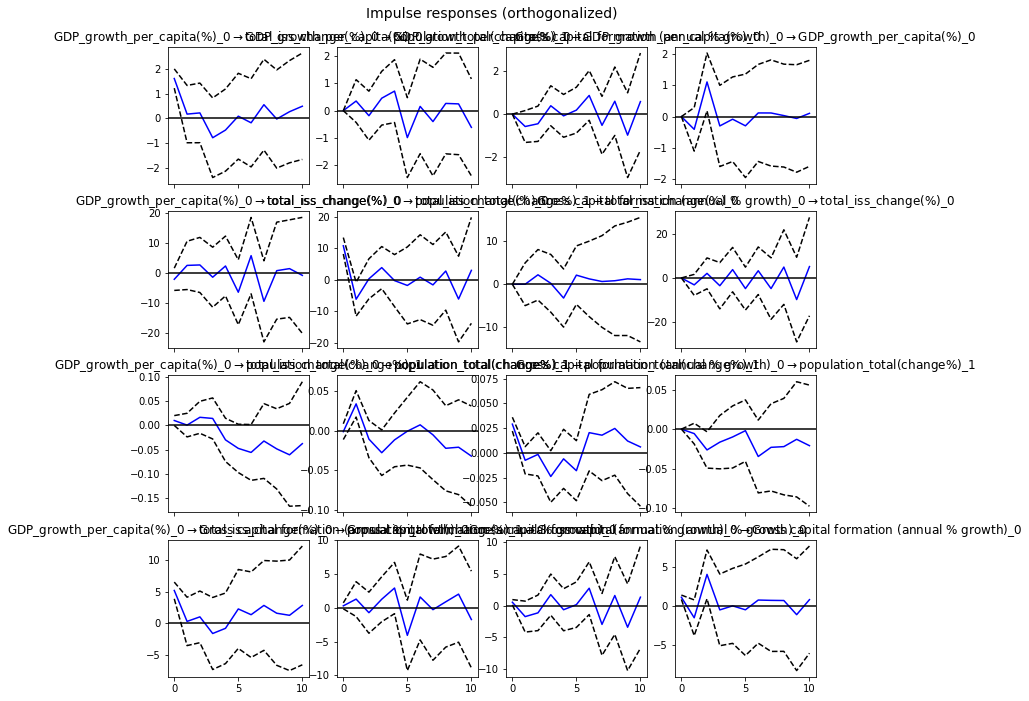

The function plots the Forecast Error Variance Decomposition
FEVD for GDP_growth_per_capita(%)_0
     GDP_growth_per_capita(%)_0  total_iss_change(%)_0  population_total(change%)_1  Gross capital formation (annual % growth)_0
0                      1.000000               0.000000                     0.000000                                     0.000000
1                      0.811297               0.038160                     0.099952                                     0.050591
2                      0.566757               0.033309                     0.109871                                     0.290063
3                      0.568933               0.063064                     0.115718                                     0.252285
4                      0.538029               0.134039                     0.103432                                     0.224500

FEVD for total_iss_change(%)_0
     GDP_growth_per_capita(%)_0  total_iss_change(%)_0  population_total(change%)_1  Gross capita

{'GDP_growth_per_capita(%)_0': 6,
 'total_iss_change(%)_0': 1,
 'population_total(change%)_1': 3,
 'Gross capital formation (annual % growth)_0': 6}

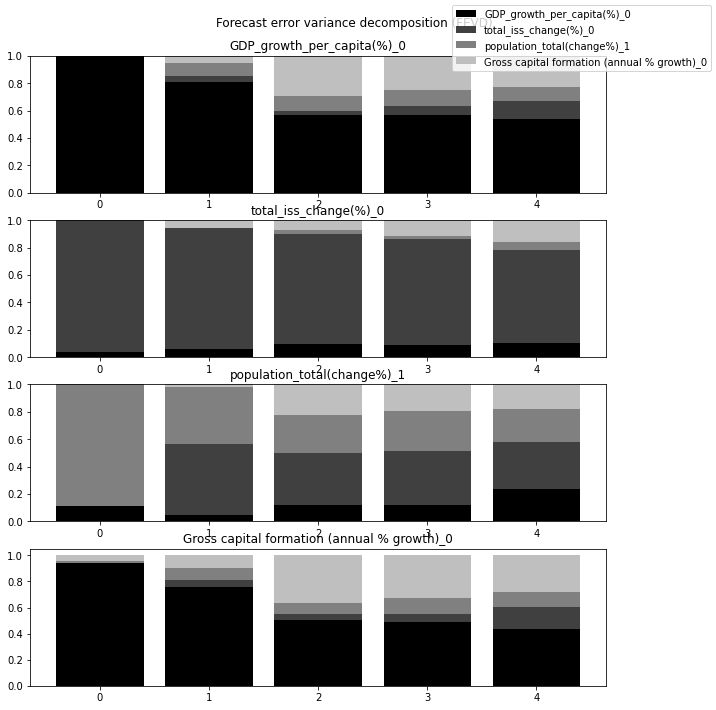

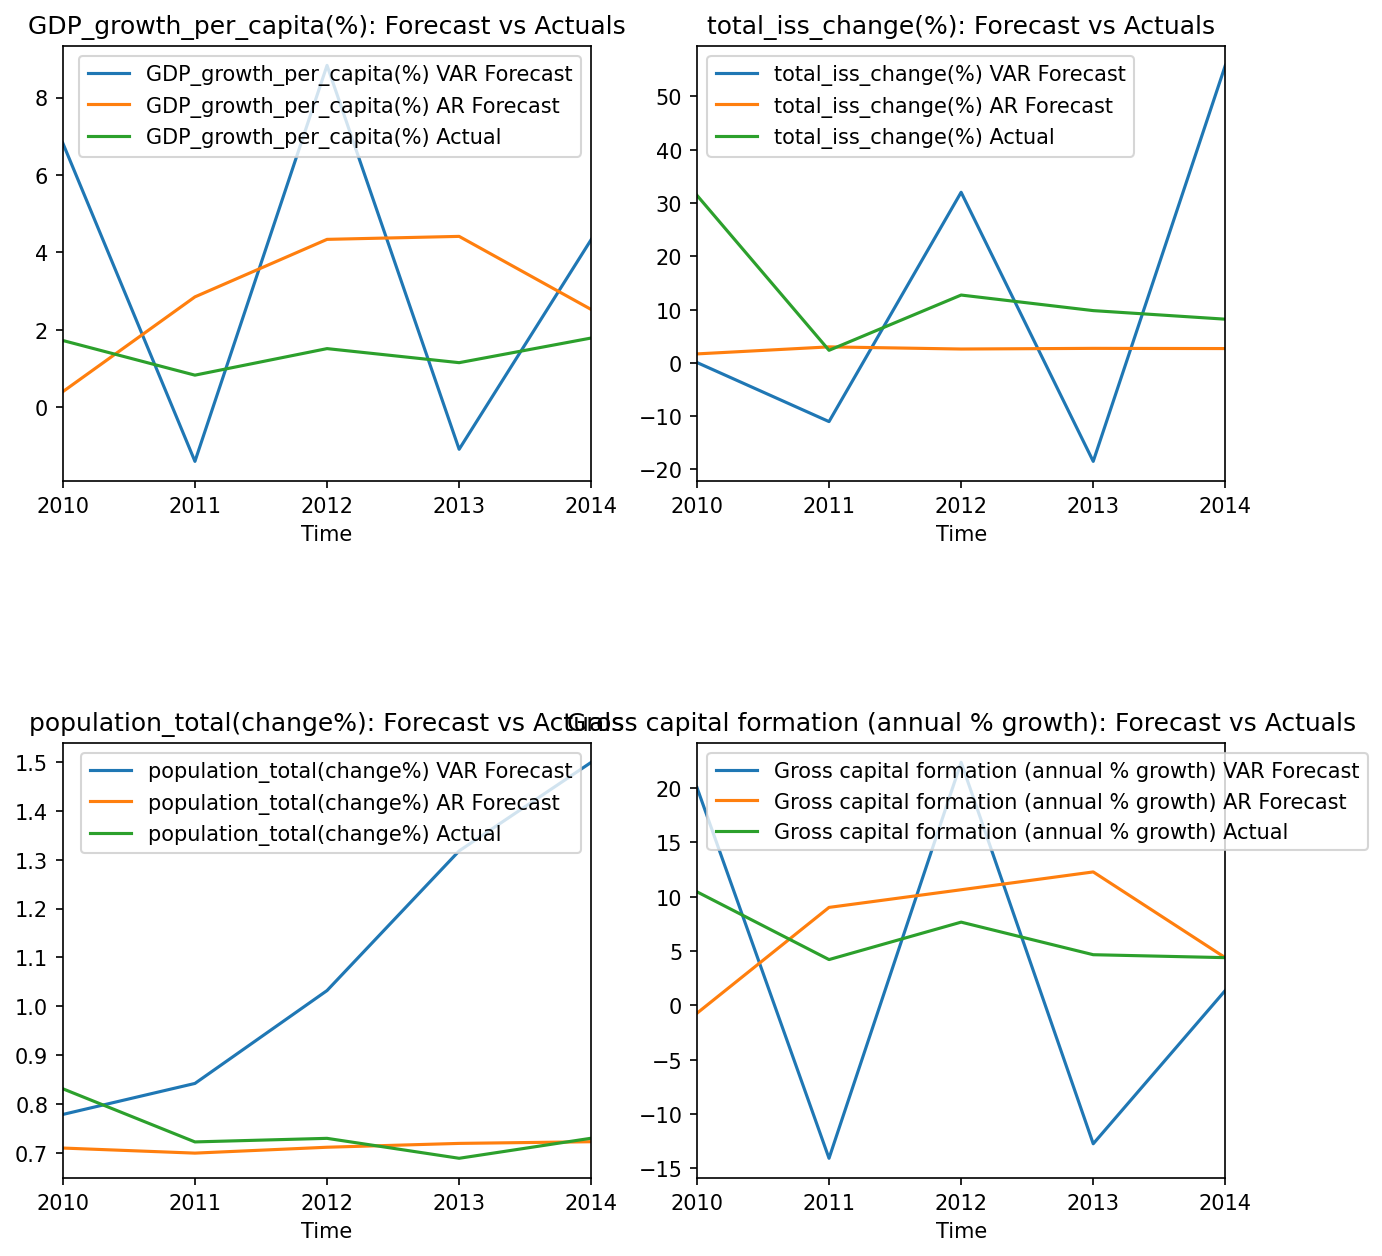

In [29]:
a = ["GDP_growth_per_capita(%)","total_iss_change(%)","population_total(change%)",'Gross capital formation (annual % growth)']
b = ["GDP_growth_per_capita(%)","total_iss_change(%)","Working_People(%)",'Gross capital formation (annual % growth)']
c = ["GDP_growth_per_capita(%)","total_iss_change(%)","population_total(change%)",'Gross fixed capital formation (annual % growth)']
d = ["GDP_growth_per_capita(%)","total_iss_change(%)","Working_People(%)",'Gross fixed capital formation (annual % growth)']

cointegration_test(usa[d].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_onediff(usa[a])

In [ ]:
VAR_AR_plot_evaluation_onediff(usa[a],num=10)

In [ ]:
a = ["GDP_growth(%)","total_iss_change(%)","population_total(change%)",'S_P500(change%)']
b = ["GDP_growth(%)","total_iss_change(%)","Working_People(%)",'S_P500(change%)']
cointegration_test(usa[a].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_onediff(usa[b])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
dummy  ::  86.7      > 60.0627   =>   True
GDP_growth(%) ::  37.64     > 40.1749   =>   False
total_iss_change(%) ::  13.44     > 24.2761   =>   False
population_total(change%) ::  3.69      > 12.3212   =>   False
S_P500(change%) ::  0.78      > 4.1296    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic     -8.027730e+00
p-value                 1.996349e-12
# lags used             0.000000e+00
# observations          6.000000e+01
Critical Value (1%)    -3.544369e+00
Critical Value (5%)    -2.911073e+00
Critical Value (10%)   -2.593190e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
dummy needs 0 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -5.341347
p-value                  0.000004
# lags used              0.000000
# observations          5

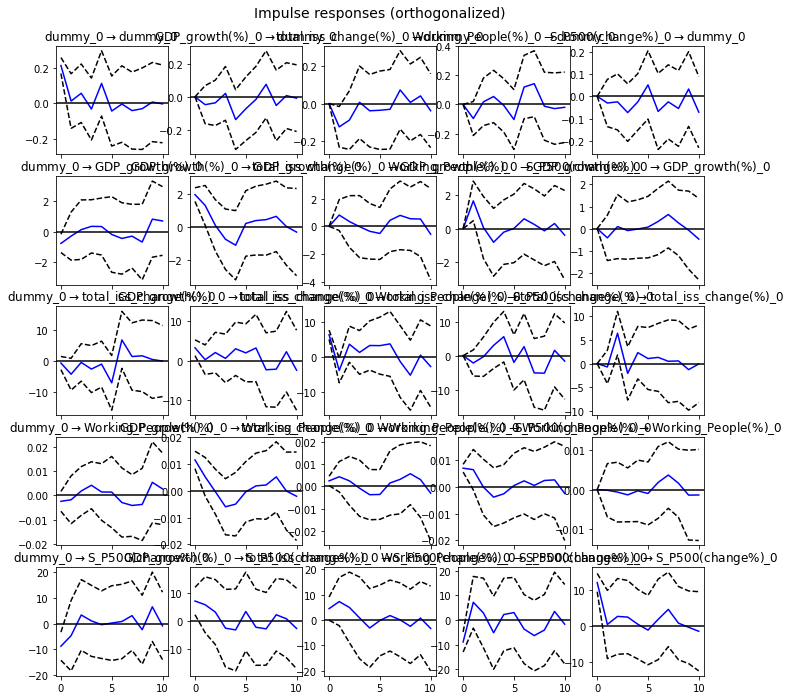

The function plots the Forecast Error Variance Decomposition
FEVD for dummy_0
      dummy_0  GDP_growth(%)_0  total_iss_change(%)_0  Working_People(%)_0  S_P500(change%)_0
0    1.000000         0.000000               0.000000             0.000000           0.000000
1    0.622988         0.030720               0.209776             0.124436           0.012079
2    0.565183         0.041298               0.267210             0.109109           0.017200
3    0.518875         0.041656               0.240895             0.128723           0.069852
4    0.481746         0.176689               0.189617             0.095579           0.056368

FEVD for GDP_growth(%)_0
      dummy_0  GDP_growth(%)_0  total_iss_change(%)_0  Working_People(%)_0  S_P500(change%)_0
0    0.131766         0.868234               0.000000             0.000000           0.000000
1    0.067458         0.565988               0.068354             0.279742           0.018458
2    0.068540         0.557597               0.079

{'dummy_0': 1,
 'GDP_growth(%)_0': 2,
 'total_iss_change(%)_0': 1,
 'Working_People(%)_0': 2,
 'S_P500(change%)_0': 1}

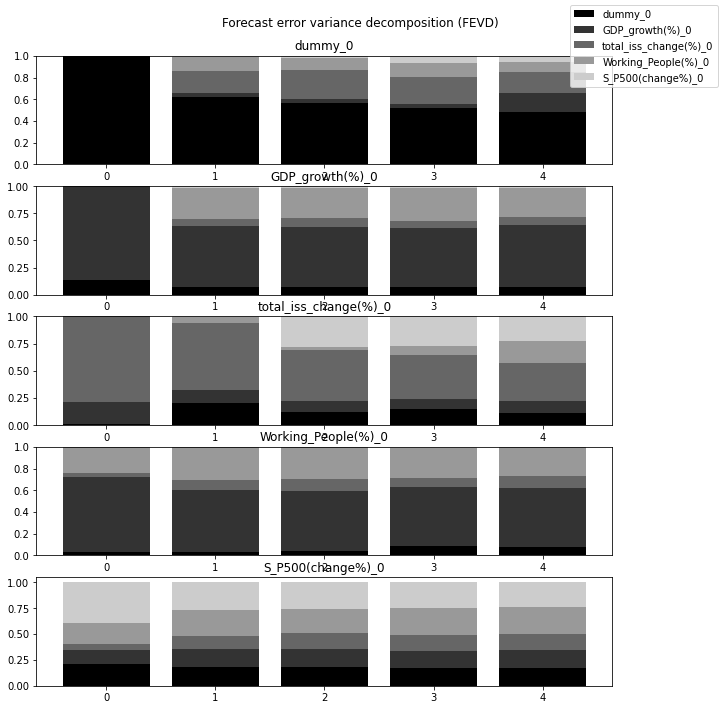

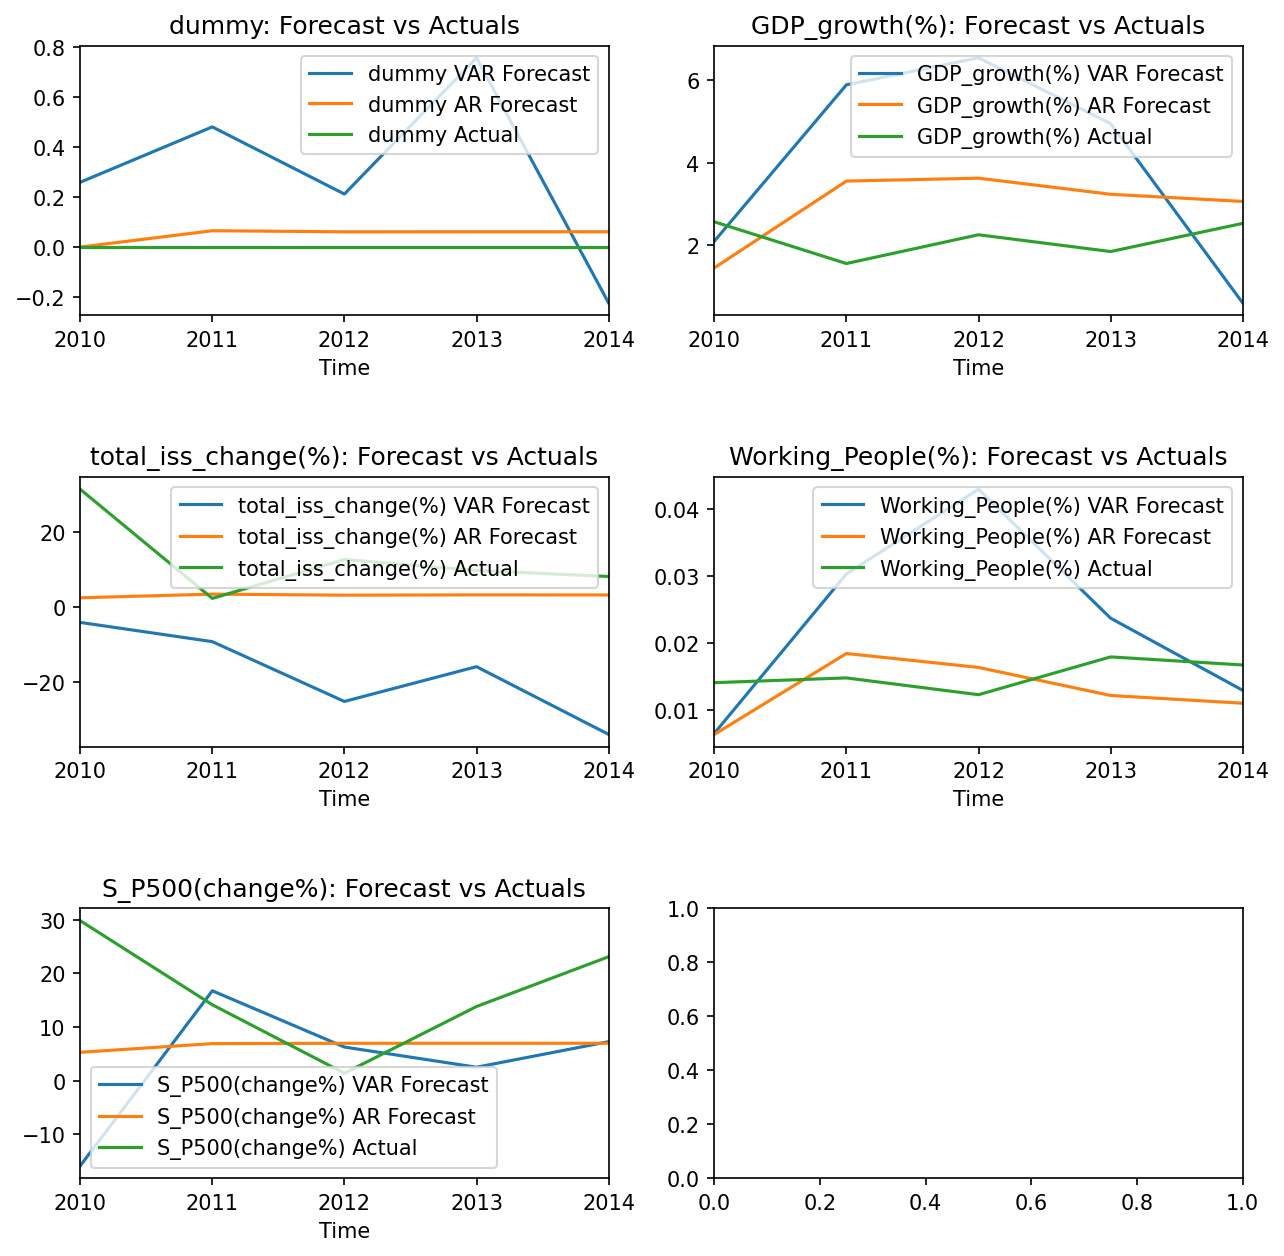

In [38]:
a = ["dummy","GDP_growth(%)","total_iss_change(%)","population_total(change%)",'S_P500(change%)']
b = ["dummy","GDP_growth(%)","total_iss_change(%)","Working_People(%)",'S_P500(change%)']
cointegration_test(usa[a].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_onediff(usa[b])

In [ ]:
a = ["GDP_growth_per_capita(%)","total_iss_change(%)",'Gross capital formation (annual % growth)']
d = ["GDP_growth_per_capita(%)","total_iss_change(%)",'Gross fixed capital formation (annual % growth)']
cointegration_test(usa[d].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_onediff(usa[d])

In [ ]:
a = ["GDP_growth(%)","total_iss_change(%)",'Gross fixed capital formation (annual % growth)']
cointegration_test(usa[a].dropna(),alpha = 0.05)

In [ ]:
cointegration_test(usa[["S_P500(change%)","Gross fixed capital formation (annual % growth)"]].dropna(),alpha = 0.05)

In [59]:
#ログヲトッテミテミル Y＝AK
usa.columns
usa = usa.dropna()
usa["ln_S_P500"]=usa["S_P500"].apply(np.log)
usa["ln_real_GDP"] = usa["real_GDP"].apply(np.log)
usa["ln_total_iss"] = usa["total_iss"].apply(np.log)
usa["ln_S_P500_diff"]=usa["S_P500"].apply(np.log).diff()
usa["ln_real_GDP_diff"] = usa["real_GDP"].apply(np.log).diff()
usa["ln_total_iss_diff"] = usa["total_iss"].apply(np.log).diff()

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ln_real_GDP_diff ::  48.07     > 29.5147   =>   True
ln_total_iss_diff ::  18.59     > 16.364    =>   True
Gross capital formation (annual % growth) ::  4.78      > 6.9406    =>   False
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Dec, 2020
Time:                     17:26:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.74722
Nobs:                     32.0000    HQIC:                  -9.11467
Log likelihood:           24.5318    FPE:                9.20735e-05
AIC:                     -9.29687    Det(Omega_mle):     6.46661e-05
--------------------------------------------------------------------
Results for equation ln_real_GDP_diff
                                                  coefficient       std. 

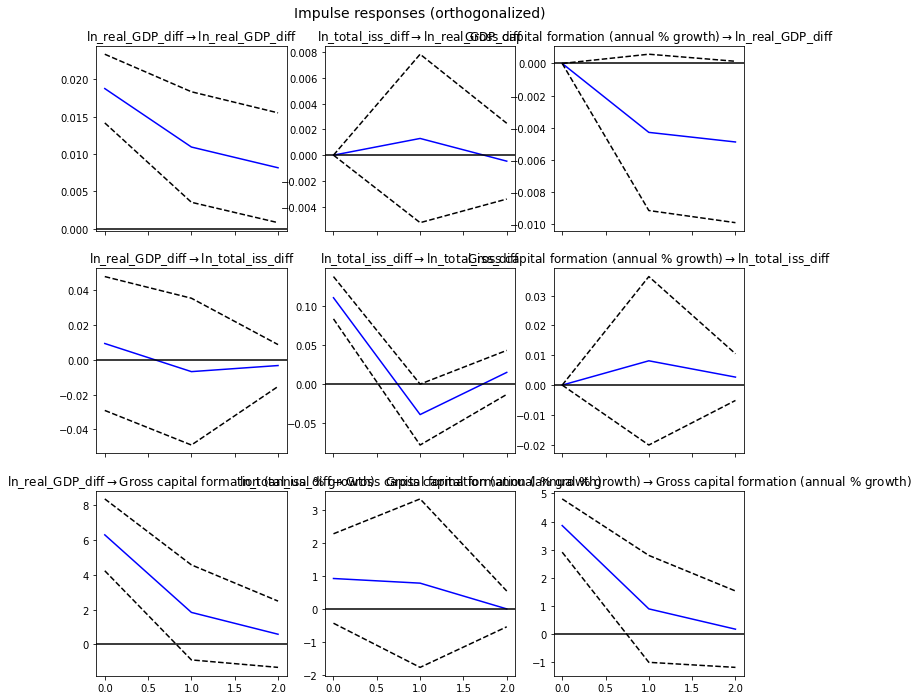

The function plots the Forecast Error Variance Decomposition
FEVD for ln_real_GDP_diff
     ln_real_GDP_diff  ln_total_iss_diff  Gross capital formation (annual % growth)
0            1.000000           0.000000                                   0.000000
1            0.959076           0.003438                                   0.037486
2            0.924007           0.003276                                   0.072717
3            0.897564           0.002942                                   0.099493
4            0.878634           0.002836                                   0.118530

FEVD for ln_total_iss_diff
     ln_real_GDP_diff  ln_total_iss_diff  Gross capital formation (annual % growth)
0            0.007091           0.992909                                   0.000000
1            0.009553           0.985708                                   0.004739
2            0.010152           0.984685                                   0.005163
3            0.011708           0.982187     

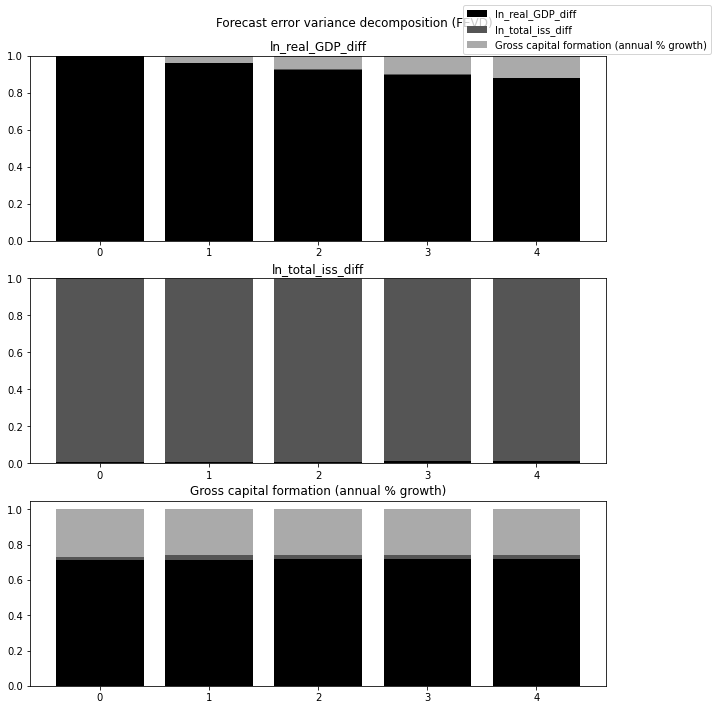

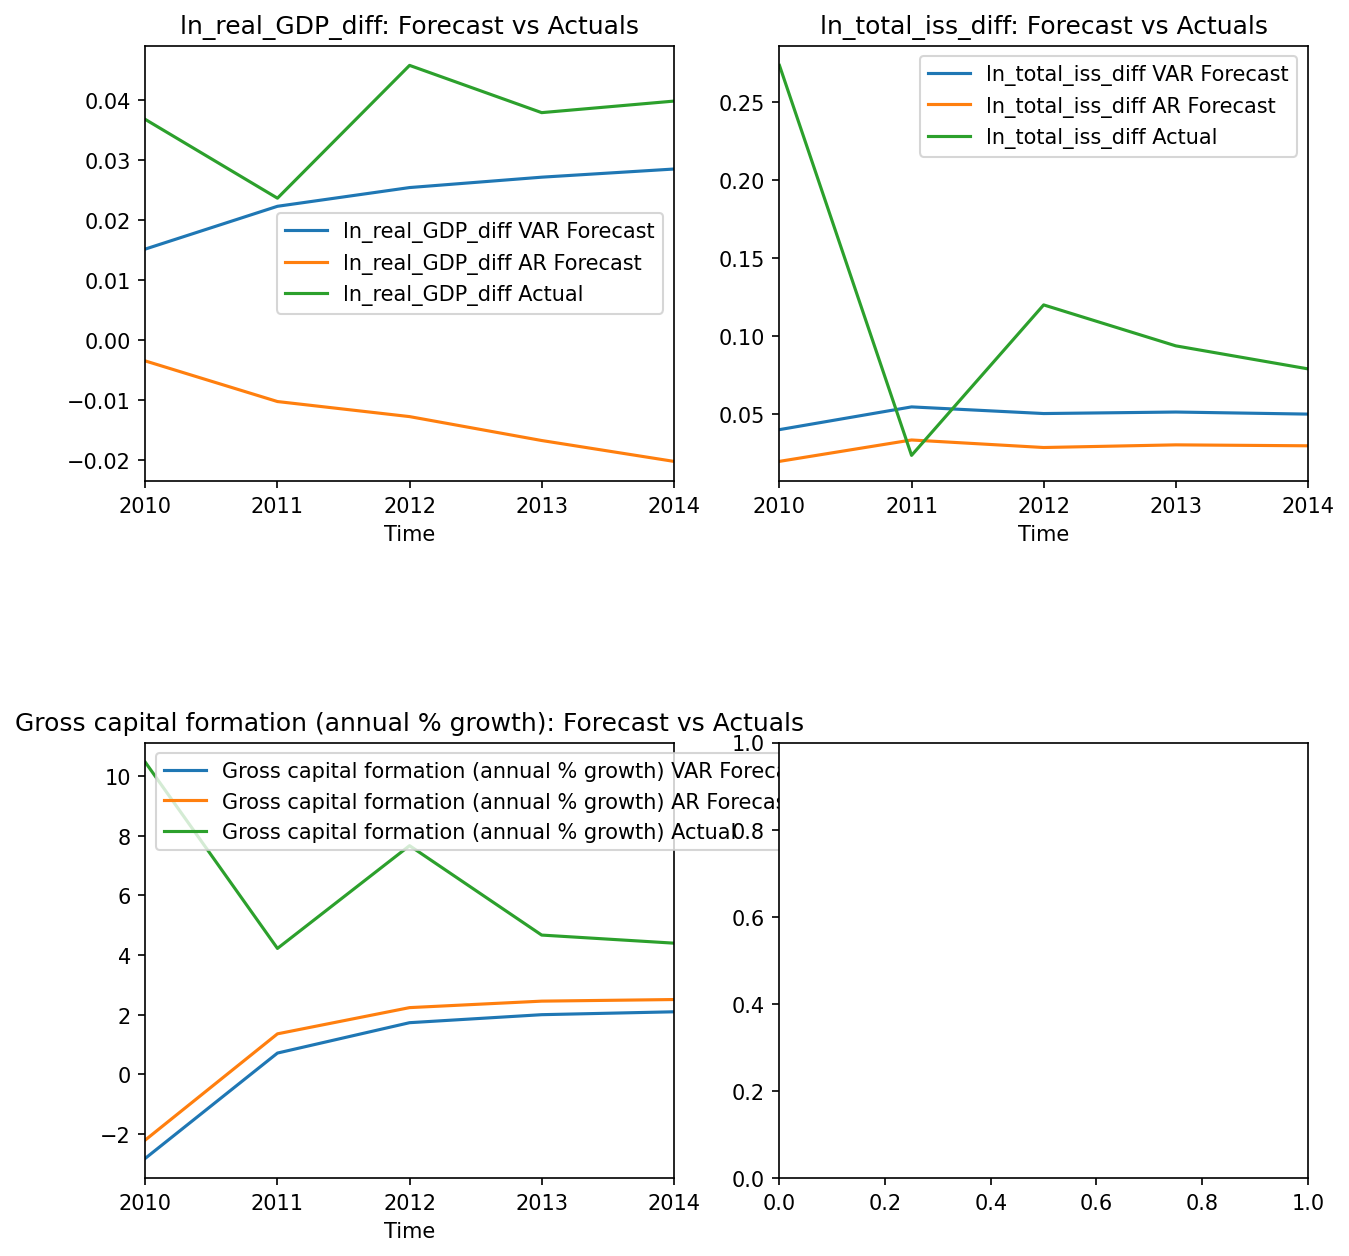

In [68]:
a = ["ln_real_GDP_diff","ln_total_iss_diff","Gross capital formation (annual % growth)"]#,"dummy"]
cointegration_test(usa[a].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(usa[a].dropna(),order = 2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ln_real_GDP_diff ::  25.13     > 29.5147   =>   False
ln_total_iss_diff ::  10.38     > 16.364    =>   False
ln_S_P500_diff ::  2.18      > 6.9406    =>   False
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Dec, 2020
Time:                     17:23:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -14.0085
Nobs:                     27.0000    HQIC:                  -15.9307
Log likelihood:           168.112    FPE:                1.49085e-07
AIC:                     -16.7441    Det(Omega_mle):     3.01476e-08
--------------------------------------------------------------------
Results for equation ln_real_GDP_diff
                          coefficient       std. error           t-stat            prob
----------

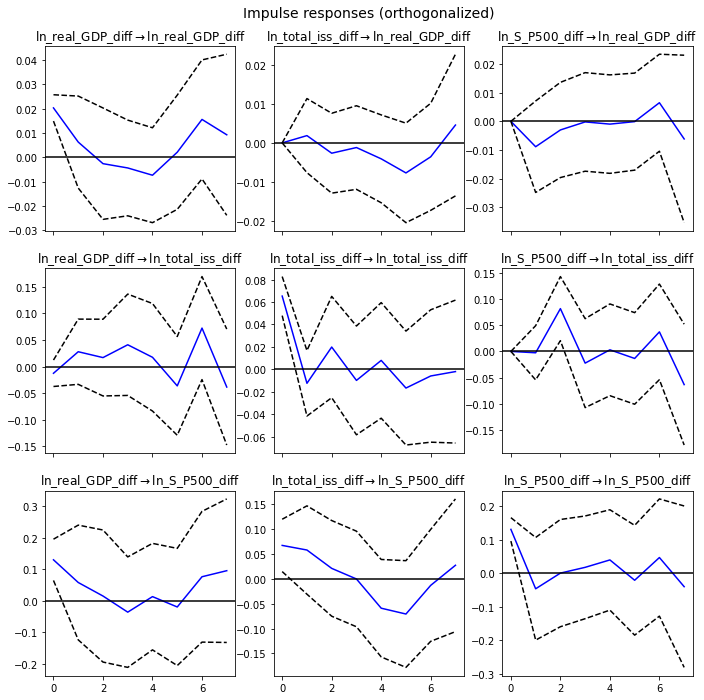

The function plots the Forecast Error Variance Decomposition
FEVD for ln_real_GDP_diff
     ln_real_GDP_diff  ln_total_iss_diff  ln_S_P500_diff
0            1.000000           0.000000        0.000000
1            0.845976           0.006494        0.147530
2            0.823486           0.018753        0.157761
3            0.827280           0.020539        0.152181
4            0.819318           0.043913        0.136769

FEVD for ln_total_iss_diff
     ln_real_GDP_diff  ln_total_iss_diff  ln_S_P500_diff
0            0.036334           0.963666        0.000000
1            0.174487           0.824236        0.001278
2            0.095776           0.378284        0.525940
3            0.192990           0.327470        0.479541
4            0.207976           0.323571        0.468453

FEVD for ln_S_P500_diff
     ln_real_GDP_diff  ln_total_iss_diff  ln_S_P500_diff
0            0.437443           0.116258        0.446298
1            0.426665           0.164816        0.408520
2    

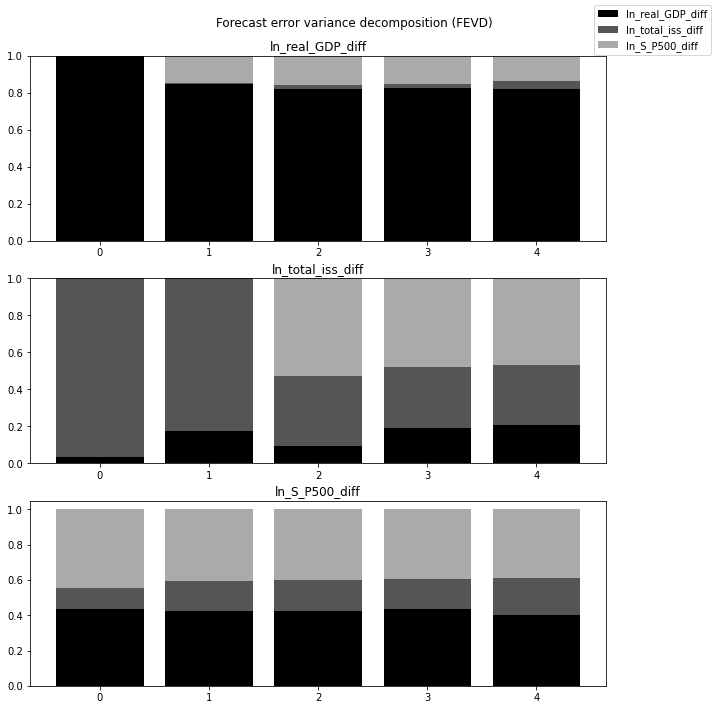

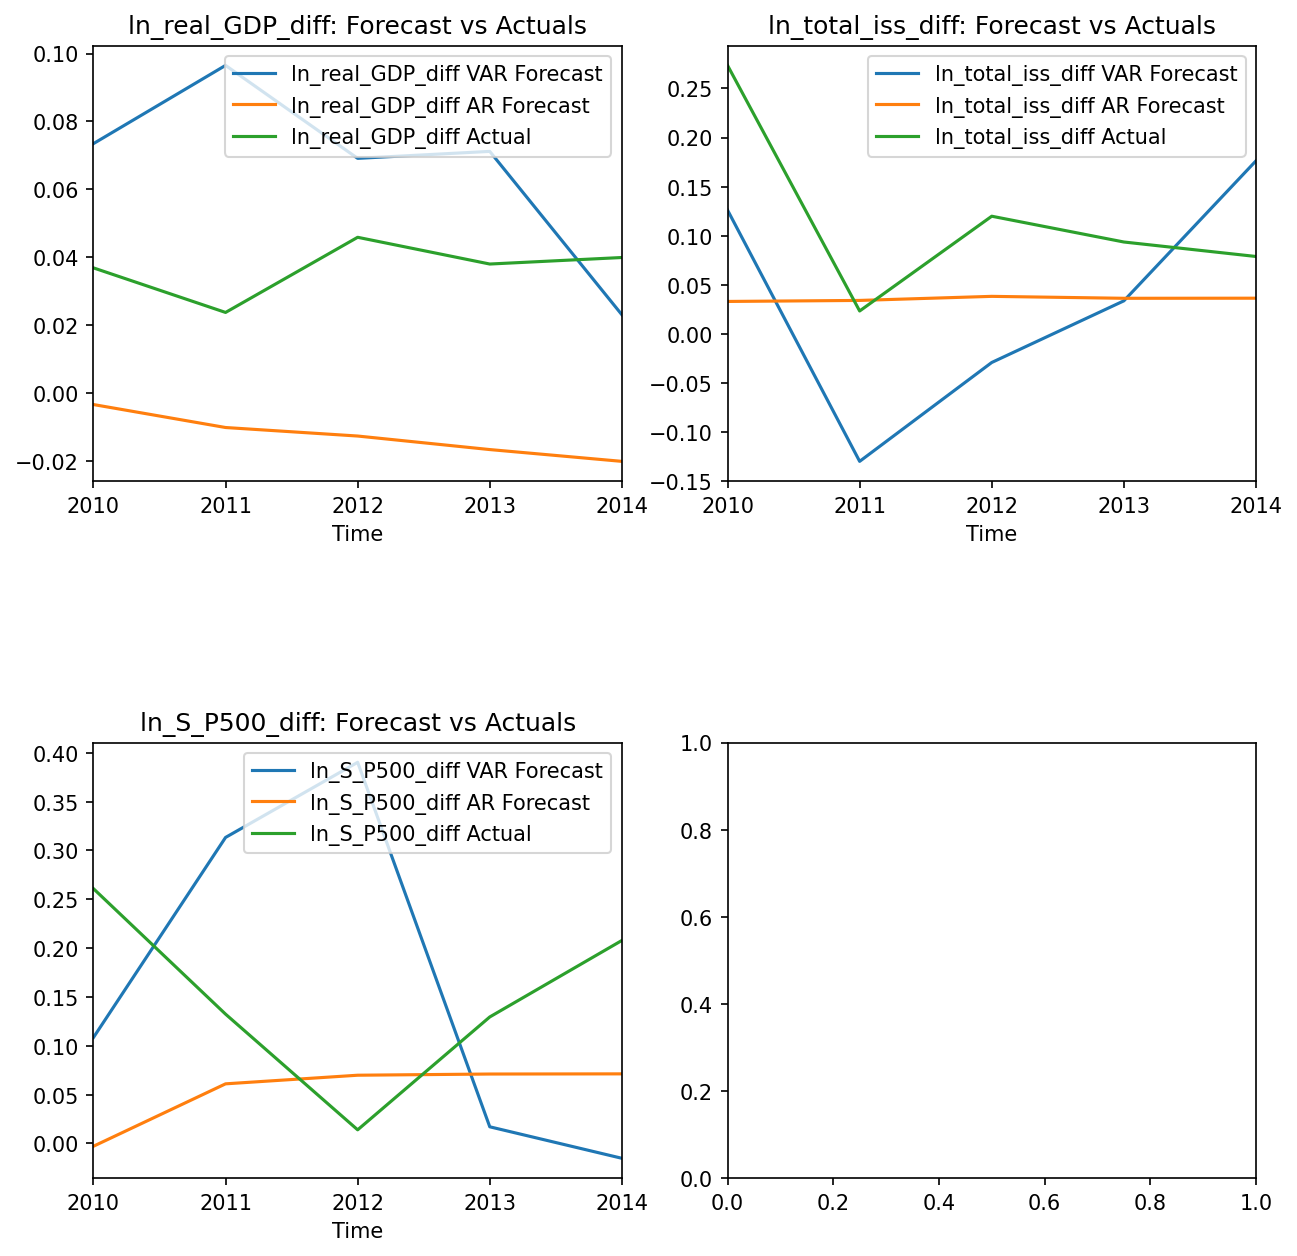

In [63]:
a = ["ln_real_GDP_diff","ln_total_iss_diff","ln_S_P500_diff"]#,"dummy"]
cointegration_test(usa[["ln_real_GDP_diff","ln_total_iss_diff","ln_S_P500_diff"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(usa[a].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ln_real_GDP ::  109.81    > 46.5716   =>   True
ln_total_iss ::  60.73     > 29.5147   =>   True
ln_S_P500 ::  26.68     > 16.364    =>   True
dummy  ::  7.57      > 6.9406    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Dec, 2020
Time:                     17:28:36
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -19.1656
Nobs:                     33.0000    HQIC:                  -19.7674
Log likelihood:           163.897    FPE:                1.93501e-09
AIC:                     -20.0726    Det(Omega_mle):     1.10054e-09
--------------------------------------------------------------------
Results for equation ln_real_GDP
                     coefficient       std. error           t-stat            

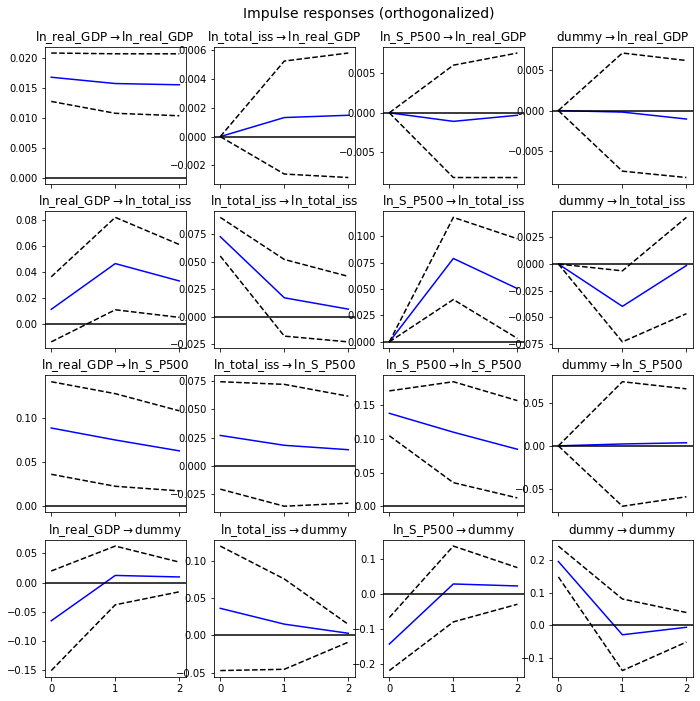

The function plots the Forecast Error Variance Decomposition
FEVD for ln_real_GDP
     ln_real_GDP  ln_total_iss  ln_S_P500     dummy
0       1.000000      0.000000   0.000000  0.000000
1       0.994479      0.003273   0.002180  0.000068
2       0.991886      0.005052   0.001619  0.001443
3       0.990555      0.005970   0.001247  0.002228
4       0.989734      0.006554   0.001070  0.002641

FEVD for ln_total_iss
     ln_real_GDP  ln_total_iss  ln_S_P500     dummy
0       0.022600      0.977400   0.000000  0.000000
1       0.144411      0.357864   0.397291  0.100434
2       0.172957      0.292391   0.453195  0.081457
3       0.188518      0.265879   0.471745  0.073857
4       0.199328      0.251392   0.479676  0.069605

FEVD for ln_S_P500
     ln_real_GDP  ln_total_iss  ln_S_P500     dummy
0       0.285083      0.026281   0.688636  0.000000
1       0.295989      0.023154   0.680755  0.000102
2       0.306470      0.022158   0.671071  0.000301
3       0.316027      0.021743   0.661860  

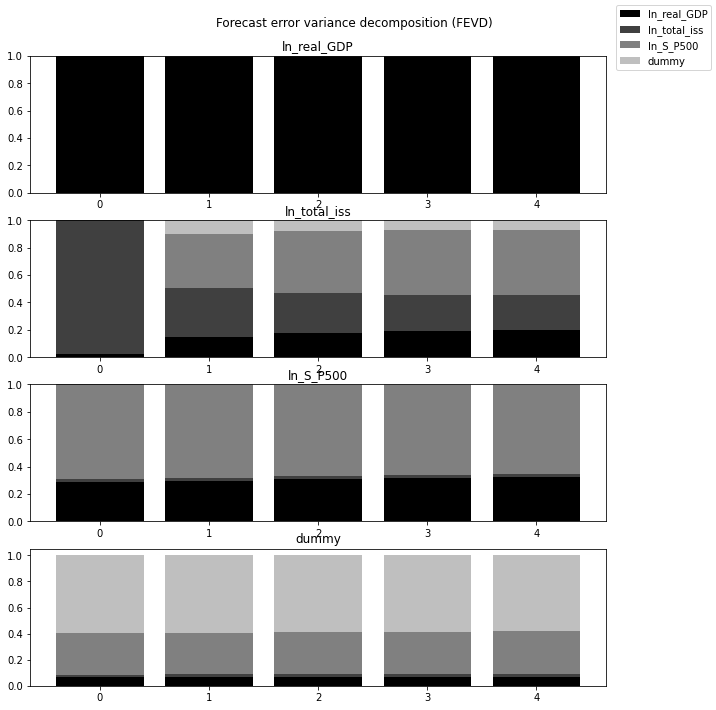

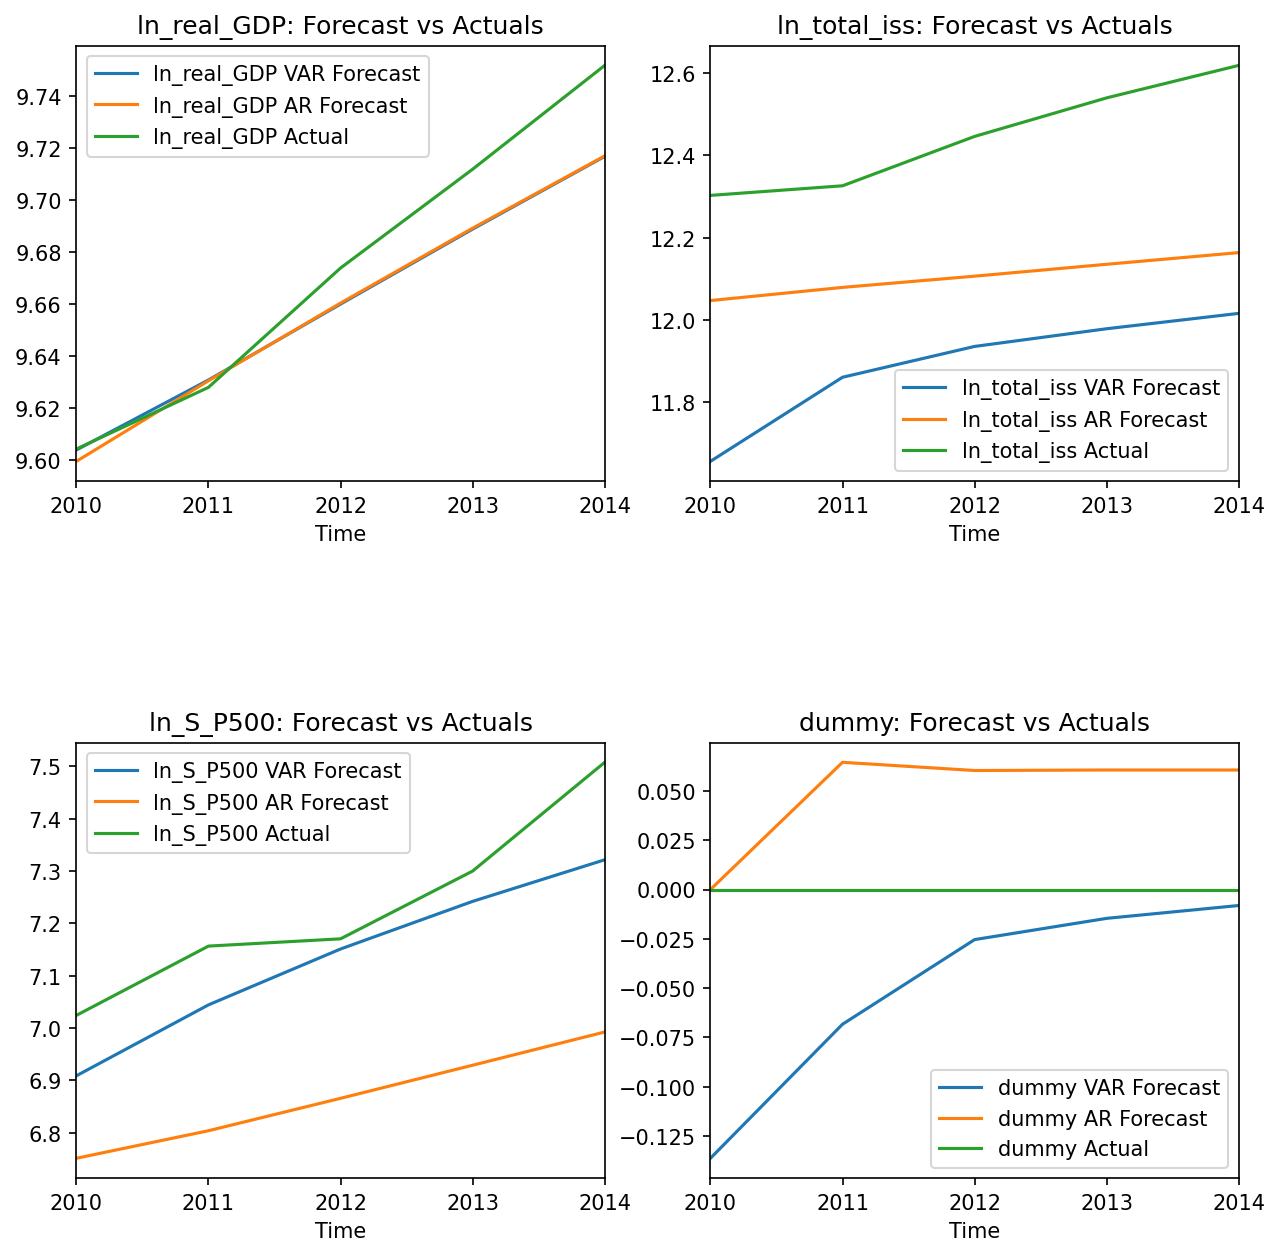

In [72]:
a = ["ln_real_GDP","ln_total_iss","ln_S_P500","dummy"]
b=["ln_real_GDP","ln_total_iss","ln_S_P500"]
cointegration_test(usa[a].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(usa[a].dropna(),order = 2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ln_total_iss_diff ::  48.07     > 24.2761   =>   True
Gross capital formation (annual % growth) ::  18.59     > 12.3212   =>   True
ln_real_GDP_diff ::  4.78      > 4.1296    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Dec, 2020
Time:                     17:41:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.74722
Nobs:                     32.0000    HQIC:                  -9.11467
Log likelihood:           24.5318    FPE:                9.20735e-05
AIC:                     -9.29687    Det(Omega_mle):     6.46661e-05
--------------------------------------------------------------------
Results for equation ln_total_iss_diff
                                                  coefficient       std. 

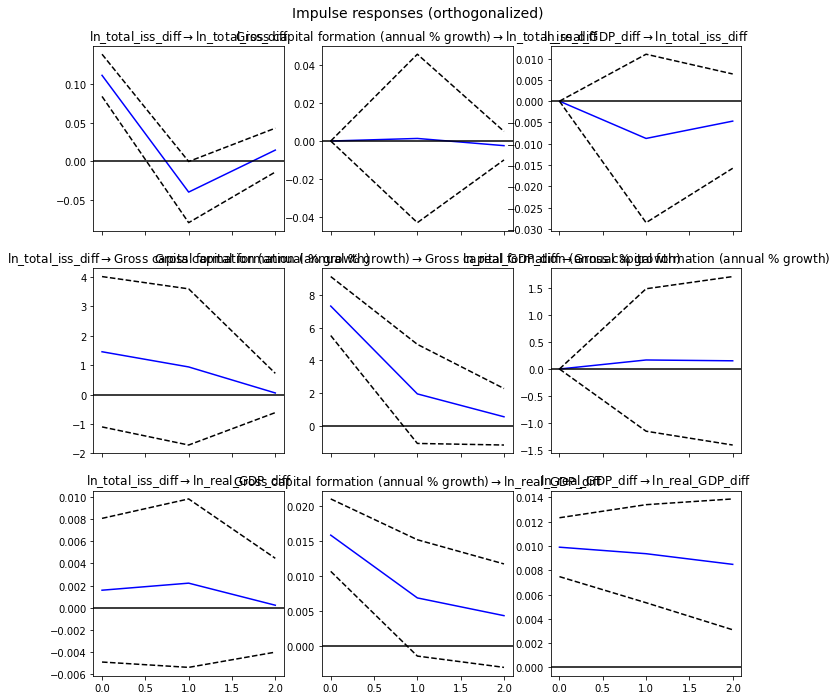

The function plots the Forecast Error Variance Decomposition
FEVD for ln_total_iss_diff
     ln_total_iss_diff  Gross capital formation (annual % growth)  ln_real_GDP_diff
0             1.000000                                   0.000000          0.000000
1             0.994399                                   0.000132          0.005469
2             0.992538                                   0.000548          0.006914
3             0.990293                                   0.000751          0.008956
4             0.988619                                   0.001021          0.010360

FEVD for Gross capital formation (annual % growth)
     ln_total_iss_diff  Gross capital formation (annual % growth)  ln_real_GDP_diff
0             0.038124                                   0.961876          0.000000
1             0.049679                                   0.949859          0.000463
2             0.049425                                   0.949735          0.000840
3             0.0495

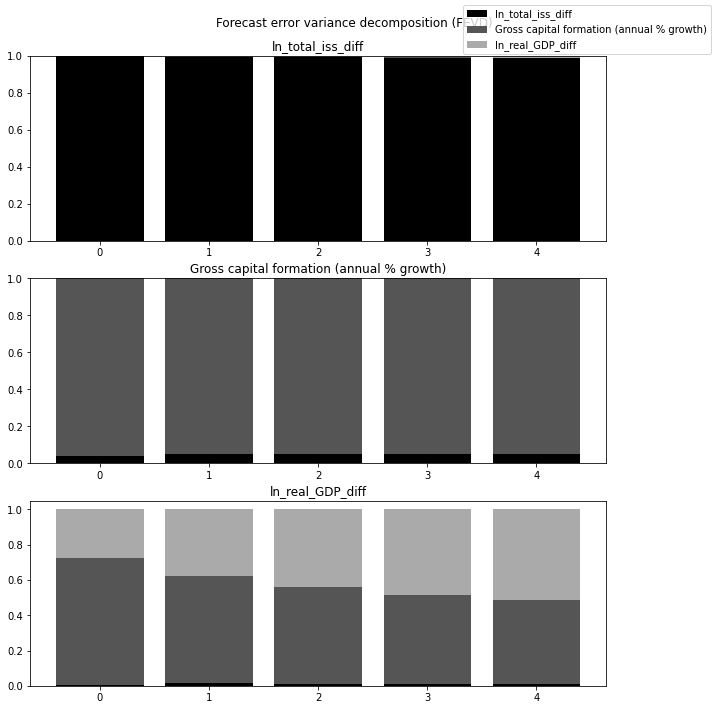

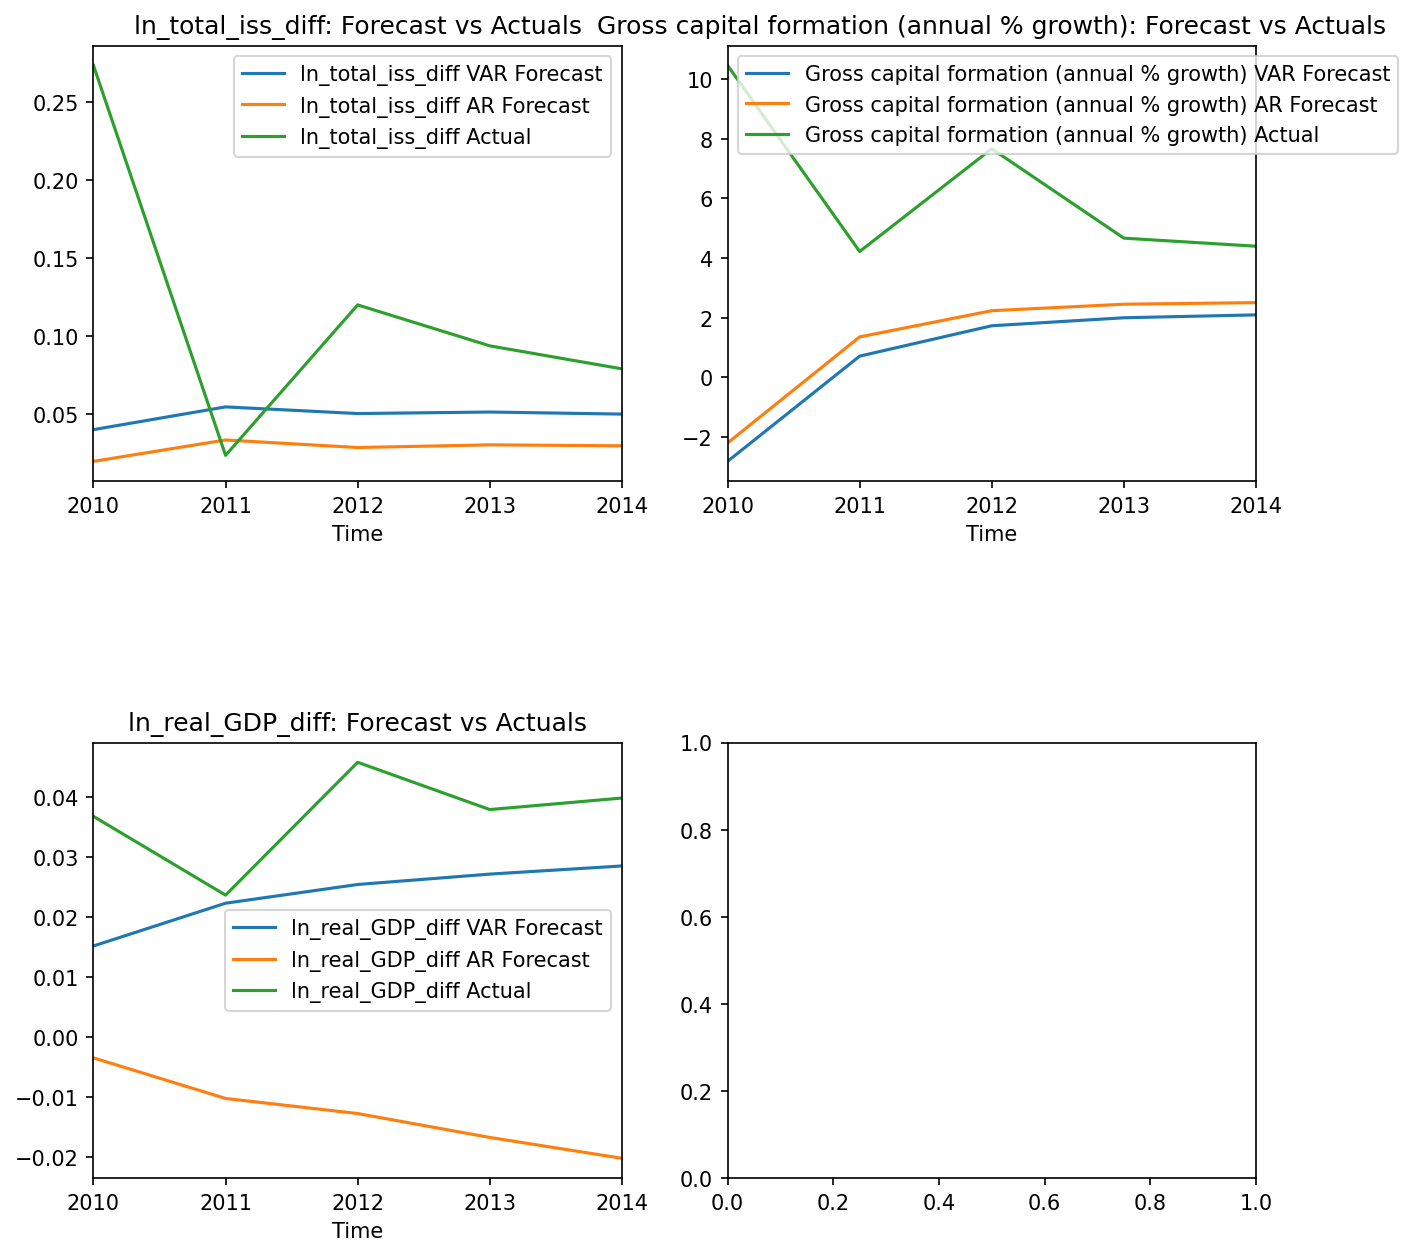

In [81]:
a = ["ln_real_GDP_diff","ln_total_iss_diff","Gross capital formation (annual % growth)","dummy"]
b=["ln_total_iss_diff","Gross capital formation (annual % growth)","ln_real_GDP_diff"]
cointegration_test(usa[b].dropna(),alpha = 0.05)
VAR_AR_plot_evaluation_nodiff(usa[b].dropna(),order = 2)